# **1. Perkenalan Dataset**


Tahap pertama, Anda harus mencari dan menggunakan dataset **tanpa label** dengan ketentuan sebagai berikut:

1. **Sumber Dataset**:  
   Dataset dapat diperoleh dari berbagai sumber, seperti public repositories (*Kaggle*, *UCI ML Repository*, *Open Data*) atau data primer yang Anda kumpulkan sendiri.
   
2. **Ketentuan Dataset**:
   - **Tanpa label**: Dataset tidak boleh memiliki label atau kelas.
   - **Jumlah Baris**: Minimal 1000 baris untuk memastikan dataset cukup besar untuk analisis yang bermakna.
   - **Tipe Data**: Harus mengandung data **kategorikal** dan **numerikal**.
     - *Kategorikal*: Misalnya jenis kelamin, kategori produk.
     - *Numerikal*: Misalnya usia, pendapatan, harga.

3. **Pembatasan**:  
   Dataset yang sudah digunakan dalam latihan clustering (seperti customer segmentation) tidak boleh digunakan.

# **2. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [2]:
import math
import numpy as np  
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# **3. Memuat Dataset**

Pada tahap ini, Anda perlu memuat dataset ke dalam notebook. Jika dataset dalam format CSV, Anda bisa menggunakan pustaka pandas untuk membacanya. Pastikan untuk mengecek beberapa baris awal dataset untuk memahami strukturnya dan memastikan data telah dimuat dengan benar.

Jika dataset berada di Google Drive, pastikan Anda menghubungkan Google Drive ke Colab terlebih dahulu. Setelah dataset berhasil dimuat, langkah berikutnya adalah memeriksa kesesuaian data dan siap untuk dianalisis lebih lanjut.

In [3]:
garisKemiskinan_df = pd.read_csv("kesejahteraan\garisKemiskinan.csv")
garisKemiskinan_df.head()

,provinsi,jenis,daerah,tahun,periode,gk
0,ACEH,MAKANAN,PERKOTAAN,2015,MARET,293697.0
1,ACEH,MAKANAN,PERKOTAAN,2015,SEPTEMBER,302128.0
2,ACEH,MAKANAN,PERKOTAAN,2016,MARET,306243.0
3,ACEH,MAKANAN,PERKOTAAN,2016,SEPTEMBER,319768.0
4,ACEH,MAKANAN,PERDESAAN,2015,MARET,297479.0


In [4]:
minimumUpah_df = pd.read_csv("kesejahteraan\minUpah.csv")
minimumUpah_df.head()

,provinsi,tahun,ump
0,ACEH,2002,330000.0
1,ACEH,2003,425000.0
2,ACEH,2004,550000.0
3,ACEH,2005,620000.0
4,ACEH,2006,820000.0


In [5]:
pengeluaran_df = pd.read_csv("kesejahteraan\pengeluaran.csv")
pengeluaran_df.head()

,provinsi,daerah,jenis,tahun,peng
0,ACEH,PERDESAAN,MAKANAN,2007,195176.0
1,ACEH,PERDESAAN,MAKANAN,2008,218781.0
2,ACEH,PERDESAAN,MAKANAN,2009,247427.0
3,ACEH,PERDESAAN,MAKANAN,2010,275749.0
4,ACEH,PERDESAAN,MAKANAN,2011,308000.0


In [6]:
rataUpah_df = pd.read_csv("kesejahteraan/rataRataUpah.csv")
rataUpah_df.head()

,provinsi,tahun,upah
0,ACEH,2015,11226
1,ACEH,2016,13627
2,ACEH,2017,14809
3,ACEH,2018,13814
4,ACEH,2019,15065


In [7]:
merged_data = garisKemiskinan_df.merge(minimumUpah_df, on=["tahun", "provinsi"]).merge(pengeluaran_df, on=["tahun", "provinsi", "daerah", "jenis"]).merge(rataUpah_df, on=["tahun", "provinsi"])
merged_data.head()

,provinsi,jenis,daerah,tahun,periode,gk,ump,peng,upah
0,ACEH,MAKANAN,PERKOTAAN,2015,MARET,293697.0,1900000.0,466355.0,11226
1,ACEH,MAKANAN,PERKOTAAN,2015,SEPTEMBER,302128.0,1900000.0,466355.0,11226
2,ACEH,MAKANAN,PERDESAAN,2015,MARET,297479.0,1900000.0,395136.0,11226
3,ACEH,MAKANAN,PERDESAAN,2015,SEPTEMBER,306737.0,1900000.0,395136.0,11226
4,ACEH,MAKANAN,PERDESAANPERKOTAAN,2015,MARET,296406.0,1900000.0,415354.0,11226



---
**Penjelasan:**

Kode ini melakukan **penggabungan (merge)** dari empat buah DataFrame:

1. `garisKemiskinan_df`
2. `minimumUpah_df`
3. `pengeluaran_df`
4. `rataUpah_df`

Semua digabung menggunakan **kolom kunci (`on`) yang sama**, yaitu:
- `"tahun"` dan `"provinsi"` untuk gabungan pertama dan terakhir.
- `"tahun"`, `"provinsi"`, `"daerah"`, dan `"jenis"` untuk gabungan dengan `pengeluaran_df`.

`merged_data.head()` digunakan untuk menampilkan **5 baris pertama** dari data yang sudah digabung, untuk dicek hasilnya.

---

In [8]:
merged_data = merged_data[
    (merged_data["provinsi"] != "INDONESIA") & 
    (merged_data["jenis"] != "TOTAL") & 
    (merged_data["daerah"] != "PERDESAANPERKOTAAN")
].reset_index(drop=True)

In [ ]:
# menyimpan dataset gabungan (marged_data)

merged_data.to_csv("Dataset_clustering.csv", index=False)

**Penjelasan:**

Setelah data digabung, dilakukan proses **filtering** untuk membuang data yang dianggap tidak diperlukan:

- Baris dengan `"provinsi"` bernilai `"INDONESIA"` dihapus, karena ini biasanya merupakan data agregat nasional.
- Baris dengan `"jenis"` bernilai `"TOTAL"` dihapus, karena mungkin hanya ingin dianalisis data yang lebih terperinci (misalnya kategori makanan vs non-makanan).
- Baris dengan `"daerah"` bernilai `"PERDESAANPERKOTAAN"` dihapus, karena ini mungkin merujuk pada gabungan desa dan kota, bukan wilayah spesifik.

Terakhir, `.reset_index(drop=True)` digunakan untuk **mengatur ulang indeks baris** setelah proses filtering, agar indeks kembali berurutan tanpa menyimpan indeks lama.

### 🔚 Ringkasan

Secara keseluruhan:

1. Menggabungkan 4 dataset berdasarkan kolom kunci seperti `tahun`, `provinsi`, dll.
2. Menyaring data agar hanya mencakup provinsi sebenarnya (bukan total nasional), jenis pengeluaran spesifik, dan daerah yang tidak merupakan gabungan desa-kota.
3. Menyiapkan data untuk analisis lebih lanjut dengan struktur yang bersih dan terstandar.

# **4. Exploratory Data Analysis (EDA)**

Pada tahap ini, Anda akan melakukan **Exploratory Data Analysis (EDA)** untuk memahami karakteristik dataset. EDA bertujuan untuk:

1. **Memahami Struktur Data**
   - Tinjau jumlah baris dan kolom dalam dataset.  
   - Tinjau jenis data di setiap kolom (numerikal atau kategorikal).

2. **Menangani Data yang Hilang**  
   - Identifikasi dan analisis data yang hilang (*missing values*). Tentukan langkah-langkah yang diperlukan untuk menangani data yang hilang, seperti pengisian atau penghapusan data tersebut.

3. **Analisis Distribusi dan Korelasi**  
   - Analisis distribusi variabel numerik dengan statistik deskriptif dan visualisasi seperti histogram atau boxplot.  
   - Periksa hubungan antara variabel menggunakan matriks korelasi atau scatter plot.

4. **Visualisasi Data**  
   - Buat visualisasi dasar seperti grafik distribusi dan diagram batang untuk variabel kategorikal.  
   - Gunakan heatmap atau pairplot untuk menganalisis korelasi antar variabel.

Tujuan dari EDA adalah untuk memperoleh wawasan awal yang mendalam mengenai data dan menentukan langkah selanjutnya dalam analisis atau pemodelan.

## **1. MEMAHAMI STRUKTUR DATA**

In [9]:
# Fungsi untuk memformat angka besar menjadi K, JT, atau M
def format_angka(n):
    if n >= 1_000_000_000:
        return f"{n / 1_000_000_000:.2f} M"
    elif n >= 1_000_000:
        return f"{n / 1_000_000:.2f} JT"
    elif n >= 1_000:
        return f"{n / 1_000:.2f} K"
    else:
        return str(n)

# Informasi Umum Dataset
print("🔹 INFORMASI DATASET: GARIS KEMISKINAN")
print("-" * 50)

baris, kolom = garisKemiskinan_df.shape
total_data = garisKemiskinan_df.size
duplikat = garisKemiskinan_df.duplicated().sum()
tipe_data_unik = garisKemiskinan_df.dtypes.nunique()
tipe_data_contoh = ', '.join(garisKemiskinan_df.dtypes.astype(str).unique())

print(f"Jumlah Baris        : {format_angka(baris)} ({baris} baris)")
print(f"Jumlah Kolom        : {format_angka(kolom)} ({kolom} kolom)")
print(f"Total Data Points   : {format_angka(total_data)} ({total_data} sel)")
print(f"Tipe Data Unik      : {tipe_data_unik} tipe (contoh: {tipe_data_contoh})")
print(f"Jumlah Duplikat     : {duplikat} baris")

print("\n📋 TIPE DATASET PER KOLOM:")
print("-" * 50)
print(garisKemiskinan_df.dtypes.value_counts())

print("\n📄 INFO LENGKAP KOLOM:")
print("-" * 50)
print(garisKemiskinan_df.info())

# Dimensi Dataset
print("\n🔹 DIMENSI DATASET")
print("-" * 50)
print(f"Dimensi (Baris, Kolom): {garisKemiskinan_df.shape}")

# Analisis Missing Value
print("\n🔹 ANALISIS MISSING VALUE")
print("-" * 50)
missing = garisKemiskinan_df.isnull().sum()
missing_percent = (missing / len(garisKemiskinan_df)) * 100
missing_df = pd.DataFrame({
    'Total Missing': missing,
    'Persentase (%)': missing_percent
})
missing_df = missing_df[missing_df['Total Missing'] > 0].sort_values(by='Total Missing', ascending=False)

if not missing_df.empty:
    print("Kolom dengan nilai hilang:")
    print(missing_df)
else:
    print("✅ Tidak ada nilai yang hilang dalam dataset.")


🔹 INFORMASI DATASET: GARIS KEMISKINAN
--------------------------------------------------
Jumlah Baris        : 5.46 K (5460 baris)
Jumlah Kolom        : 6 (6 kolom)
Total Data Points   : 32.76 K (32760 sel)
Tipe Data Unik      : 3 tipe (contoh: object, int64, float64)
Jumlah Duplikat     : 0 baris

📋 TIPE DATASET PER KOLOM:
--------------------------------------------------
object     4
int64      1
float64    1
Name: count, dtype: int64

📄 INFO LENGKAP KOLOM:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5460 entries, 0 to 5459
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   provinsi  5460 non-null   object 
 1   jenis     5460 non-null   object 
 2   daerah    5460 non-null   object 
 3   tahun     5460 non-null   int64  
 4   periode   5460 non-null   object 
 5   gk        5261 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 256.1+ KB
No

In [10]:
# Fungsi untuk memformat angka besar menjadi K, JT, atau M
def format_angka(n):
    if n >= 1_000_000_000:
        return f"{n / 1_000_000_000:.2f} M"
    elif n >= 1_000_000:
        return f"{n / 1_000_000:.2f} JT"
    elif n >= 1_000:
        return f"{n / 1_000:.2f} K"
    else:
        return str(n)

# Informasi Umum Dataset
print("🔹 INFORMASI DATASET: MINIMUM UPAH")
print("-" * 50)

baris, kolom = minimumUpah_df.shape
total_data = minimumUpah_df.size
duplikat = minimumUpah_df.duplicated().sum()
tipe_data_unik = minimumUpah_df.dtypes.nunique()
tipe_data_contoh = ', '.join(minimumUpah_df.dtypes.astype(str).unique())

print(f"Jumlah Baris        : {format_angka(baris)} ({baris} baris)")
print(f"Jumlah Kolom        : {format_angka(kolom)} ({kolom} kolom)")
print(f"Total Data Points   : {format_angka(total_data)} ({total_data} sel)")
print(f"Tipe Data Unik      : {tipe_data_unik} tipe (contoh: {tipe_data_contoh})")
print(f"Jumlah Duplikat     : {duplikat} baris")

print("\n📋 TIPE DATASET PER KOLOM:")
print("-" * 50)
print(minimumUpah_df.dtypes.value_counts())

print("\n📄 INFO LENGKAP KOLOM:")
print("-" * 50)
print(minimumUpah_df.info())

# Dimensi Dataset
print("\n🔹 DIMENSI DATASET")
print("-" * 50)
print(f"Dimensi (Baris, Kolom): {minimumUpah_df.shape}")

# Analisis Missing Value
print("\n🔹 ANALISIS MISSING VALUE")
print("-" * 50)
missing = minimumUpah_df.isnull().sum()
missing_percent = (missing / len(minimumUpah_df)) * 100
missing_df = pd.DataFrame({
    'Total Missing': missing,
    'Persentase (%)': missing_percent
})
missing_df = missing_df[missing_df['Total Missing'] > 0].sort_values(by='Total Missing', ascending=False)

if not missing_df.empty:
    print("Kolom dengan nilai hilang:")
    print(missing_df)
else:
    print("✅ Tidak ada nilai yang hilang dalam dataset.")


🔹 INFORMASI DATASET: MINIMUM UPAH
--------------------------------------------------
Jumlah Baris        : 735 (735 baris)
Jumlah Kolom        : 3 (3 kolom)
Total Data Points   : 2.21 K (2205 sel)
Tipe Data Unik      : 3 tipe (contoh: object, int64, float64)
Jumlah Duplikat     : 0 baris

📋 TIPE DATASET PER KOLOM:
--------------------------------------------------
object     1
int64      1
float64    1
Name: count, dtype: int64

📄 INFO LENGKAP KOLOM:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   provinsi  735 non-null    object 
 1   tahun     735 non-null    int64  
 2   ump       711 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 17.4+ KB
None

🔹 DIMENSI DATASET
--------------------------------------------------
Dimensi (Baris, Kolom): (735, 3)

🔹 ANALISIS MISSING VALU

In [11]:
# Informasi Dataset: pengeluaran_df
print("🔹 INFORMASI DATASET: PENGELUARAN")
print("-" * 50)

baris, kolom = pengeluaran_df.shape
total_data = pengeluaran_df.size
duplikat = pengeluaran_df.duplicated().sum()
tipe_data_unik = pengeluaran_df.dtypes.nunique()
tipe_data_contoh = ', '.join(pengeluaran_df.dtypes.astype(str).unique())

print(f"Jumlah Baris        : {format_angka(baris)} ({baris} baris)")
print(f"Jumlah Kolom        : {format_angka(kolom)} ({kolom} kolom)")
print(f"Total Data Points   : {format_angka(total_data)} ({total_data} sel)")
print(f"Tipe Data Unik      : {tipe_data_unik} tipe (contoh: {tipe_data_contoh})")
print(f"Jumlah Duplikat     : {duplikat} baris")

print("\n📋 TIPE DATASET PER KOLOM:")
print("-" * 50)
print(pengeluaran_df.dtypes.value_counts())

print("\n📄 INFO LENGKAP KOLOM:")
print("-" * 50)
print(pengeluaran_df.info())

print("\n🔹 DIMENSI DATASET")
print("-" * 50)
print(f"Dimensi (Baris, Kolom): {pengeluaran_df.shape}")

print("\n🔹 ANALISIS MISSING VALUE")
print("-" * 50)
missing = pengeluaran_df.isnull().sum()
missing_percent = (missing / len(pengeluaran_df)) * 100
missing_df = pd.DataFrame({
    'Total Missing': missing,
    'Persentase (%)': missing_percent
})
missing_df = missing_df[missing_df['Total Missing'] > 0].sort_values(by='Total Missing', ascending=False)

if not missing_df.empty:
    print("Kolom dengan nilai hilang:")
    print(missing_df)
else:
    print("✅ Tidak ada nilai yang hilang dalam dataset.")


🔹 INFORMASI DATASET: PENGELUARAN
--------------------------------------------------
Jumlah Baris        : 4.62 K (4620 baris)
Jumlah Kolom        : 5 (5 kolom)
Total Data Points   : 23.10 K (23100 sel)
Tipe Data Unik      : 3 tipe (contoh: object, int64, float64)
Jumlah Duplikat     : 0 baris

📋 TIPE DATASET PER KOLOM:
--------------------------------------------------
object     3
int64      1
float64    1
Name: count, dtype: int64

📄 INFO LENGKAP KOLOM:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4620 entries, 0 to 4619
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   provinsi  4620 non-null   object 
 1   daerah    4620 non-null   object 
 2   jenis     4620 non-null   object 
 3   tahun     4620 non-null   int64  
 4   peng      4512 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 180.6+ KB
None

🔹 DIMENSI DATASET
----------------------

In [12]:
# Informasi Dataset: rataUpah_df
print("🔹 INFORMASI DATASET: RATA-RATA UPAH")
print("-" * 50)

baris, kolom = rataUpah_df.shape
total_data = rataUpah_df.size
duplikat = rataUpah_df.duplicated().sum()
tipe_data_unik = rataUpah_df.dtypes.nunique()
tipe_data_contoh = ', '.join(rataUpah_df.dtypes.astype(str).unique())

print(f"Jumlah Baris        : {format_angka(baris)} ({baris} baris)")
print(f"Jumlah Kolom        : {format_angka(kolom)} ({kolom} kolom)")
print(f"Total Data Points   : {format_angka(total_data)} ({total_data} sel)")
print(f"Tipe Data Unik      : {tipe_data_unik} tipe (contoh: {tipe_data_contoh})")
print(f"Jumlah Duplikat     : {duplikat} baris")

print("\n📋 TIPE DATASET PER KOLOM:")
print("-" * 50)
print(rataUpah_df.dtypes.value_counts())

print("\n📄 INFO LENGKAP KOLOM:")
print("-" * 50)
print(rataUpah_df.info())

print("\n🔹 DIMENSI DATASET")
print("-" * 50)
print(f"Dimensi (Baris, Kolom): {rataUpah_df.shape}")

print("\n🔹 ANALISIS MISSING VALUE")
print("-" * 50)
missing = rataUpah_df.isnull().sum()
missing_percent = (missing / len(rataUpah_df)) * 100
missing_df = pd.DataFrame({
    'Total Missing': missing,
    'Persentase (%)': missing_percent
})
missing_df = missing_df[missing_df['Total Missing'] > 0].sort_values(by='Total Missing', ascending=False)

if not missing_df.empty:
    print("Kolom dengan nilai hilang:")
    print(missing_df)
else:
    print("✅ Tidak ada nilai yang hilang dalam dataset.")


🔹 INFORMASI DATASET: RATA-RATA UPAH
--------------------------------------------------
Jumlah Baris        : 280 (280 baris)
Jumlah Kolom        : 3 (3 kolom)
Total Data Points   : 840 (840 sel)
Tipe Data Unik      : 2 tipe (contoh: object, int64)
Jumlah Duplikat     : 0 baris

📋 TIPE DATASET PER KOLOM:
--------------------------------------------------
int64     2
object    1
Name: count, dtype: int64

📄 INFO LENGKAP KOLOM:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   provinsi  280 non-null    object
 1   tahun     280 non-null    int64 
 2   upah      280 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 6.7+ KB
None

🔹 DIMENSI DATASET
--------------------------------------------------
Dimensi (Baris, Kolom): (280, 3)

🔹 ANALISIS MISSING VALUE
------------------------------------------

In [13]:
# Fungsi untuk memformat angka besar menjadi K, JT, atau M
def format_angka(n):
    if n >= 1_000_000_000:
        return f"{n / 1_000_000_000:.2f} M"
    elif n >= 1_000_000:
        return f"{n / 1_000_000:.2f} JT"
    elif n >= 1_000:
        return f"{n / 1_000:.2f} K"
    else:
        return str(n)

# Informasi Umum Dataset
print("🔹 INFORMASI DATASET: DATASET GABUNGAN")
print("-" * 50)

baris, kolom = merged_data.shape
total_data = merged_data.size
duplikat = merged_data.duplicated().sum()
tipe_data_unik = merged_data.dtypes.nunique()
tipe_data_contoh = ', '.join(merged_data.dtypes.astype(str).unique())

print(f"Jumlah Baris        : {format_angka(baris)} ({baris} baris)")
print(f"Jumlah Kolom        : {format_angka(kolom)} ({kolom} kolom)")
print(f"Total Data Points   : {format_angka(total_data)} ({total_data} sel)")
print(f"Tipe Data Unik      : {tipe_data_unik} tipe (contoh: {tipe_data_contoh})")
print(f"Jumlah Duplikat     : {duplikat} baris")

print("\n📋 TIPE DATASET PER KOLOM:")
print("-" * 50)
print(merged_data.dtypes.value_counts())

print("\n📄 INFO LENGKAP KOLOM:")
print("-" * 50)
print(merged_data.info())

# Dimensi Dataset
print("\n🔹 DIMENSI DATASET")
print("-" * 50)
print(f"Dimensi (Baris, Kolom): {merged_data.shape}")

# Analisis Missing Value
print("\n🔹 ANALISIS MISSING VALUE")
print("-" * 50)
missing = garisKemiskinan_df.isnull().sum()
missing_percent = (missing / len(merged_data)) * 100
missing_df = pd.DataFrame({
    'Total Missing': missing,
    'Persentase (%)': missing_percent
})
missing_df = missing_df[missing_df['Total Missing'] > 0].sort_values(by='Total Missing', ascending=False)

if not missing_df.empty:
    print("Kolom dengan nilai hilang:")
    print(missing_df)
else:
    print("✅ Tidak ada nilai yang hilang dalam dataset.")


🔹 INFORMASI DATASET: DATASET GABUNGAN
--------------------------------------------------
Jumlah Baris        : 2.18 K (2176 baris)
Jumlah Kolom        : 9 (9 kolom)
Total Data Points   : 19.58 K (19584 sel)
Tipe Data Unik      : 3 tipe (contoh: object, int64, float64)
Jumlah Duplikat     : 0 baris

📋 TIPE DATASET PER KOLOM:
--------------------------------------------------
object     4
float64    3
int64      2
Name: count, dtype: int64

📄 INFO LENGKAP KOLOM:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2176 entries, 0 to 2175
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   provinsi  2176 non-null   object 
 1   jenis     2176 non-null   object 
 2   daerah    2176 non-null   object 
 3   tahun     2176 non-null   int64  
 4   periode   2176 non-null   object 
 5   gk        2144 non-null   float64
 6   ump       2176 non-null   float64
 7   peng      2144 non-nul

**ringkasan penjelasan** dari keempat hasil analisis dataset (`garisKemiskinan_df`, `minimumUpah_df`, `pengeluaran_df`, dan `rataUpah_df`, `merged_data (DATASET GABUNGAN)`):

---

### 🔹 1. `garisKemiskinan_df` – *Dataset Garis Kemiskinan*

- **Ukuran Dataset:** Memiliki 5.460 baris dan 6 kolom (sekitar 32.760 data poin).
- **Tipe Data:** Terdapat 3 tipe data utama: `object`, `int64`, dan `float64`.
- **Kualitas Data:** 
  - Tidak ditemukan data duplikat.
  - Terdapat **199 nilai hilang (3.64%)** pada kolom `gk`, yang perlu ditangani pada tahap pembersihan data.
- **Karakteristik:** Didominasi oleh data kategorikal (4 kolom bertipe `object`), menunjukkan banyak dimensi deskriptif seperti nama daerah, provinsi, dll.

---

### 🔹 2. `minimumUpah_df` – *Dataset Upah Minimum Provinsi*

- **Ukuran Dataset:** Lebih kecil dari sebelumnya, hanya berisi 735 baris dan 3 kolom (2.205 data poin).
- **Tipe Data:** Masih mencakup 3 tipe (`object`, `int64`, `float64`) meski jumlah kolom sedikit.
- **Kualitas Data:**
  - Tidak ada data duplikat.
  - Kolom `ump` memiliki **24 nilai hilang (3.27%)**, yang mungkin disebabkan oleh data yang belum tersedia atau tidak dilaporkan.
- **Karakteristik:** Sederhana namun penting untuk analisis tren upah minimum tiap provinsi dari waktu ke waktu.

---

### 🔹 3. `pengeluaran_df` – *Dataset Rata-rata Pengeluaran*

- **Ukuran Dataset:** 4.620 baris dan 5 kolom (total 23.100 data poin).
- **Tipe Data:** Sama seperti sebelumnya, mencakup `object`, `int64`, dan `float64`.
- **Kualitas Data:**
  - Tidak terdapat duplikat.
  - Kolom `peng` mengandung **108 nilai hilang (2.34%)**.
- **Karakteristik:** Menyimpan informasi pengeluaran berdasarkan provinsi, jenis daerah, dan tahun. Cukup seimbang antara data kategorikal dan numerik.

---

### 🔹 4. `rataUpah_df` – *Dataset Rata-rata Upah*

- **Ukuran Dataset:** Paling kecil di antara keempatnya, dengan 280 baris dan 3 kolom (840 data poin).
- **Tipe Data:** Hanya terdiri dari `object` dan `int64`, tanpa `float`.
- **Kualitas Data:**
  - Tidak ditemukan nilai duplikat maupun missing value.
- **Karakteristik:** Dataset bersih dan siap pakai untuk analisis langsung, cocok untuk visualisasi tren atau perbandingan upah antar tahun/provinsi.

---

### 🔹 5. `merged_data` – *Dataset Hasil Gabungan dari Beberapa Sumber*

- **Ukuran Dataset:** Terdiri dari 2.176 baris dan 9 kolom, menghasilkan total 19.584 data poin.
- **Tipe Data:** Memuat 3 tipe data — dengan dominasi `object` (4 kolom), diikuti `float64` (3 kolom), dan `int64` (2 kolom).
- **Kualitas Data:**
  - Tidak ditemukan duplikat.
  - Terdapat **199 nilai hilang (9.15%)** pada kolom `gk`, yang merupakan hasil penggabungan data dari `garisKemiskinan_df`.
- **Karakteristik:** Merupakan hasil integrasi dari beberapa dataset, sehingga memuat lebih banyak atribut untuk analisis komprehensif. Cocok untuk model prediksi atau pemetaan antar variabel seperti hubungan pengeluaran, upah, dan garis kemiskinan.

---

### ✅ Kesimpulan Umum

| Dataset              | Baris  | Kolom | Missing Value     | Duplikat | Catatan Tambahan                             |
|----------------------|--------|--------|--------------------|----------|----------------------------------------------|
| `garisKemiskinan_df` | 5.460  | 6      | ✅ (3.6%) di `gk`   | ❌ Tidak | Data dominan kategorikal                     |
| `minimumUpah_df`     | 735    | 3      | ✅ (3.3%) di `ump`  | ❌ Tidak | Fokus pada UMP tiap provinsi dan tahun       |
| `pengeluaran_df`     | 4.620  | 5      | ✅ (2.3%) di `peng` | ❌ Tidak | Seimbang kategorikal dan numerik             |
| `rataUpah_df`        | 280    | 3      | ❌ Tidak ada        | ❌ Tidak | Dataset paling bersih dan siap digunakan     |
| `dataset_gabungan`   | 2.176  | 9      | ✅ (9.1%) di `gk`   | ❌ Tidak | Gabungan multi-dataset, cocok untuk analitik |

---

#### **TAHAP SELANJUTNYA SAYA AKAN MENGGUNAKAN DATASET GABUNGAN (merged_data)**

---

## **2. MENANGANI DATA YANG HILANG** 

In [14]:
print(f"Jumlah data hilang pada dataset: \n{merged_data.isna().sum()}")
print(f"Jumlah data ganda pada dataset: {merged_data.duplicated().sum()}")

Jumlah data hilang pada dataset: 
provinsi     0
jenis        0
daerah       0
tahun        0
periode      0
gk          32
ump          0
peng        32
upah         0
dtype: int64
Jumlah data ganda pada dataset: 0



---

**Penjelasan:**

**- Terdapat 32 data yang hilang pada fitur `gk`.**

**- Terdapat 32 data yang hilang pada fitur `peng`.**

**- Tidak ada data duplikat dataset.**

---

## **3.ANALISIS DISTRIBUSI DAN KOLERASI**

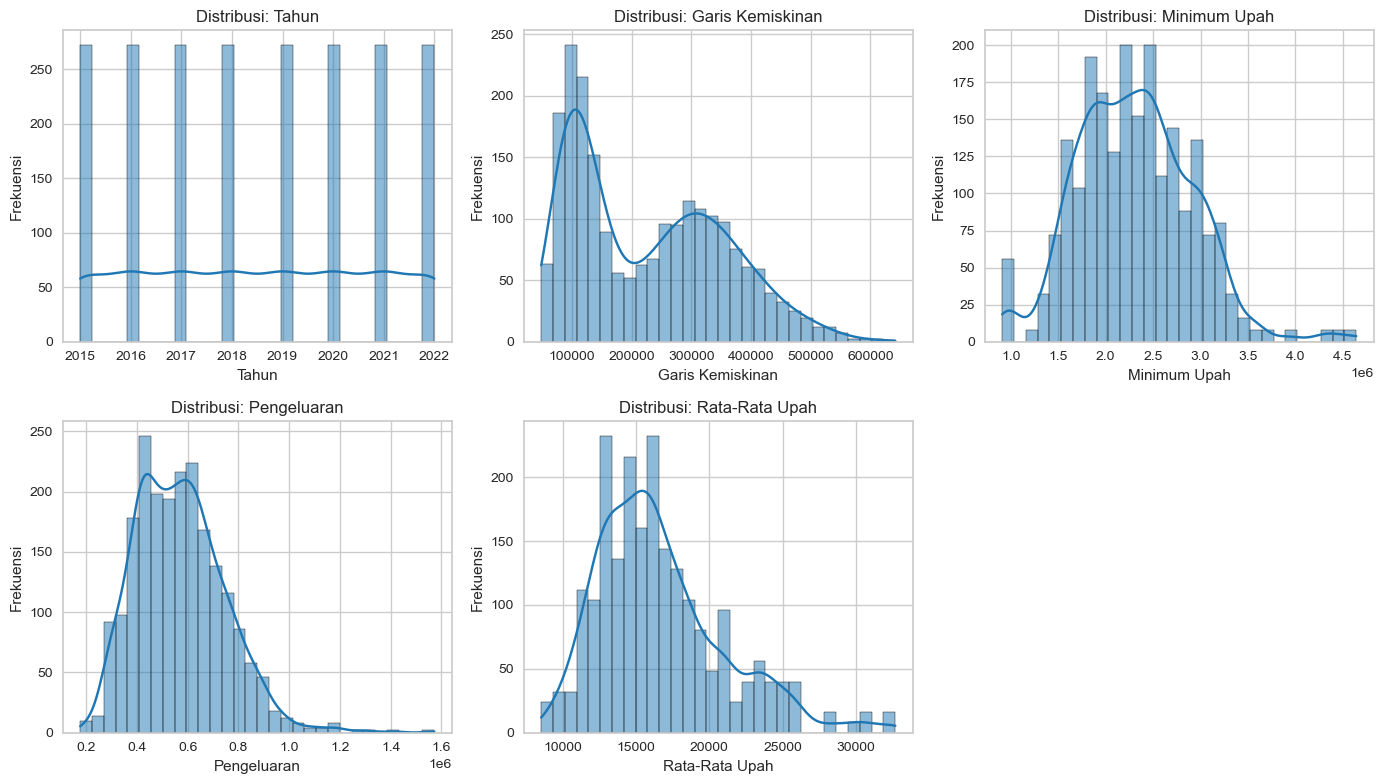

In [15]:
# ambil kolom numerik
numeric_columns = merged_data.select_dtypes(include=[np.number]).columns.tolist()

# mapping nama kolom ke label yang lebih deskriptif
label_mapping = {
    "gk": "Garis Kemiskinan",
    "ump": "Minimum Upah",
    "peng": "Pengeluaran",
    "upah": "Rata-Rata Upah",
    "tahun": "Tahun"
}

# plot histogram distribusi
plt.figure(figsize=(14, 8))

for i, col in enumerate(numeric_columns, 1):
    plt.subplot(2, 3, i)  
    sns.histplot(merged_data[col], bins=30, kde=True, color="tab:blue")

    label = label_mapping.get(col, col)
    plt.title(f"Distribusi: {label}")
    plt.xlabel(label)
    plt.ylabel("Frekuensi")

plt.tight_layout()
plt.show()



---

## **📊 Analisis Distribusi Variabel Numerik**

*Visualisasi berikut menampilkan distribusi lima variabel numerik utama dalam dataset gabungan. Masing-masing plot memperlihatkan bentuk penyebaran data beserta karakteristik statistiknya.*

### 🔹 1. **Tahun**
- Distribusi merata dari tahun 2015 hingga 2022.
- Tidak ada ketimpangan atau missing data yang terlihat.
- Menunjukkan bahwa data dikumpulkan secara konsisten setiap tahunnya.

### 🔹 2. **Garis Kemiskinan**
- Distribusi **bimodal**, dengan dua kelompok utama:
  - Kelompok 1: sekitar 100–150 ribu.
  - Kelompok 2: sekitar 300–400 ribu.
- **Right-skewed**, mengindikasikan ada wilayah dengan garis kemiskinan sangat tinggi.

### 🔹 3. **Minimum Upah (UMP)**
- Bentuk distribusi **mendekati normal**, namun sedikit **miring ke kanan**.
- Sebagian besar upah minimum berada di kisaran 1,5–3 juta.
- Terdapat beberapa **outlier** di atas 4 juta, mencerminkan variasi antar wilayah.

### 🔹 4. **Pengeluaran**
- Distribusi **right-skewed** menyerupai log-normal.
- Mayoritas rumah tangga menghabiskan 400 ribu hingga 800 ribu.
- Ekor kanan yang panjang menunjukkan adanya kelompok dengan pengeluaran jauh lebih tinggi.

### 🔹 5. **Rata-Rata Upah**
- Distribusi **right-skewed**, dengan puncak di 12–15 ribu.
- Outlier menunjukkan ketimpangan pendapatan antar pekerja.
- Memberi gambaran bahwa sebagian kecil penduduk memperoleh upah sangat tinggi dibanding mayoritas lainnya.

---

### **✅ Kesimpulan Umum**
- Hampir semua variabel numerik (kecuali tahun) memiliki distribusi **miring ke kanan**.
- Ini mencerminkan **ketimpangan** dalam aspek ekonomi seperti upah dan pengeluaran.
- Distribusi yang tidak normal ini penting untuk diperhatikan saat melakukan analisis statistik lanjutan, karena bisa mempengaruhi hasil uji atau model prediktif.

---

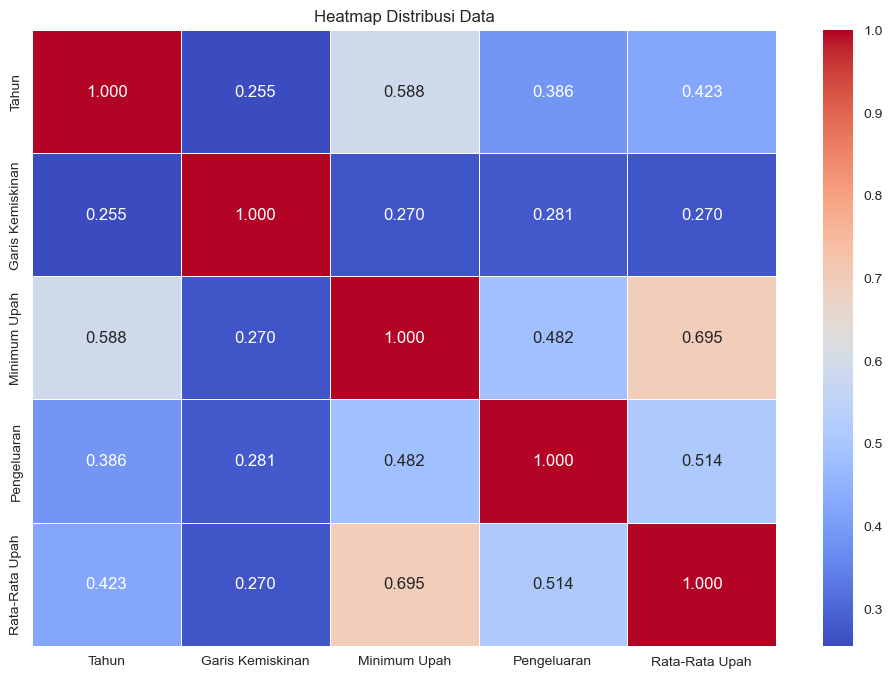

In [16]:
labels = ["Tahun", "Garis Kemiskinan", "Minimum Upah", "Pengeluaran", "Rata-Rata Upah"]

plt.figure(figsize=(12, 8))
sns.heatmap(merged_data[numeric_columns].corr(), annot=True, cmap="coolwarm", fmt=".3f", linewidths=0.5, xticklabels=labels, yticklabels=labels)
plt.title("Heatmap Distribusi Data")
plt.xlabel(None)
plt.show()


---

## 🔥 **Penjelasan Heatmap**
- **Warna**:
  - Warna **merah tua** → korelasi tinggi positif (mendekati 1).
  - Warna **biru tua** → korelasi rendah (mendekati 0) atau negatif (jika ada).
- **Nilai korelasi Pearson**:
  - Rentangnya dari **-1 (negatif sempurna)** sampai **1 (positif sempurna)**.
  - Nilai **0** artinya tidak ada hubungan linear.

---

## 📊 **Interpretasi Tiap Hubungan**

| Variabel 1        | Variabel 2          | Korelasi | Interpretasi                                                                 |
|------------------|----------------------|----------|------------------------------------------------------------------------------|
| Tahun            | Minimum Upah         | 0.588    | Korelasi positif sedang; upah minimum cenderung naik dari tahun ke tahun.   |
| Tahun            | Pengeluaran          | 0.386    | Korelasi lemah; pengeluaran sedikit meningkat seiring waktu.               |
| Tahun            | Rata-Rata Upah       | 0.423    | Korelasi lemah–sedang; rata-rata upah meningkat seiring waktu.             |
| Garis Kemiskinan | variabel lain        | ~0.25–0.28| Korelasi rendah terhadap semua variabel lain. Menandakan pengaruh terbatas.|
| Minimum Upah     | Rata-Rata Upah       | **0.695**| Korelasi positif kuat; wilayah dengan upah minimum tinggi cenderung punya rata-rata upah yang lebih tinggi. |
| Minimum Upah     | Pengeluaran          | 0.482    | Korelasi sedang; upah minimum mempengaruhi daya beli masyarakat.            |
| Pengeluaran      | Rata-Rata Upah       | 0.514    | Korelasi sedang; makin tinggi upah rata-rata, makin tinggi pengeluaran.     |

---

## 🧠 **Insight yang Bisa Diambil**
1. **Upah minimum dan rata-rata upah** sangat berkaitan → konsistensi kebijakan upah di suatu daerah bisa memengaruhi keseluruhan penghasilan pekerja.
2. **Pengeluaran** cukup dipengaruhi oleh **upah rata-rata dan minimum**, yang menunjukkan adanya hubungan antara **pendapatan dan konsumsi**.
3. **Garis kemiskinan** punya korelasi rendah dengan variabel lain → mungkin karena ditentukan oleh kebijakan atau standar nasional yang tidak terlalu fleksibel terhadap kondisi lokal.
4. **Tahun** memiliki korelasi sedang terhadap variabel ekonomi → menandakan adanya tren ekonomi yang meningkat seiring waktu.

---

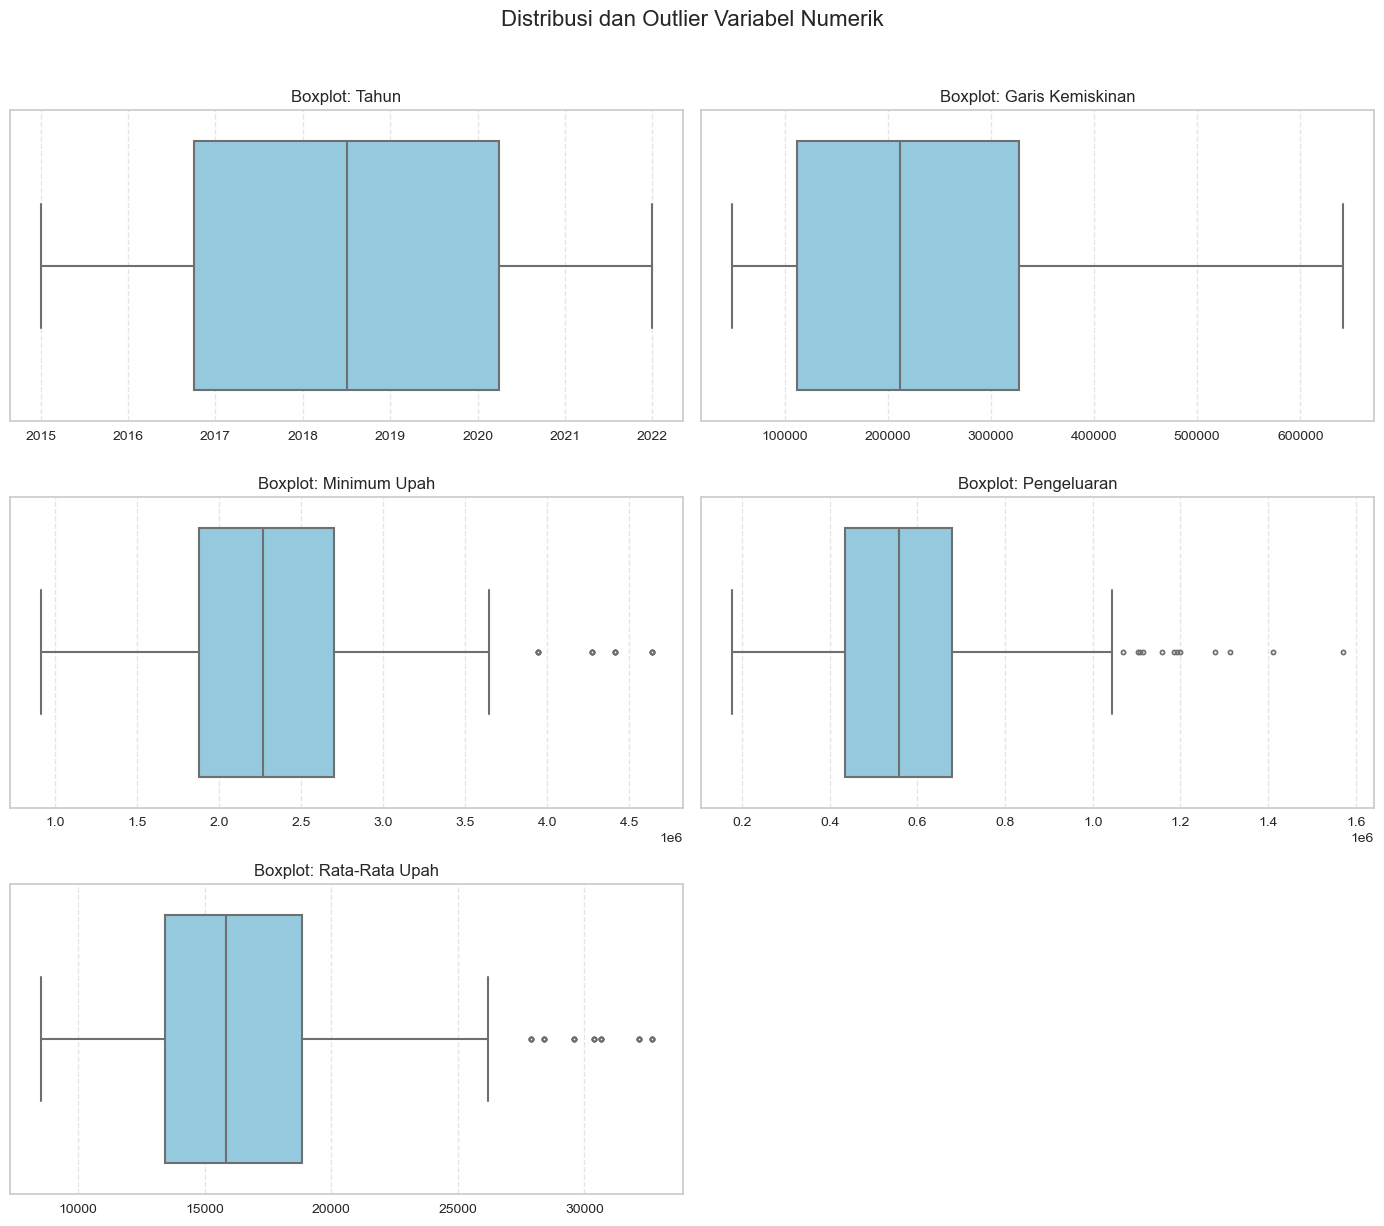

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ambil kolom numerik dari dataset gabungan
numeric_columns = merged_data.select_dtypes(include=[np.number]).columns

# Inisialisasi judul kolom dalam bahasa Indonesia
column_titles = {
    "tahun": "Tahun",
    "gk": "Garis Kemiskinan",
    "ump": "Minimum Upah",
    "peng": "Pengeluaran",
    "upah": "Rata-Rata Upah"
}

# Tentukan jumlah plot
num_plots = len(numeric_columns)
rows = (num_plots + 1) // 2  # dua kolom per baris

plt.figure(figsize=(14, rows * 4))

for i, col in enumerate(numeric_columns, 1):
    plt.subplot(rows, 2, i)
    sns.boxplot(x=merged_data[col], color="skyblue", fliersize=3, linewidth=1.5)

    title = column_titles.get(col, col)
    plt.title(f"Boxplot: {title}", fontsize=12)
    plt.xlabel("")  # Hilangkan label X default
    plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.suptitle("Distribusi dan Outlier Variabel Numerik", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()



---

## 📦 Visualisasi Distribusi & Outlier Variabel Numerik

Gambar di atas menampilkan **boxplot** untuk lima variabel numerik dalam dataset gabungan. Boxplot digunakan untuk memahami penyebaran data, mendeteksi outlier, serta melihat persebaran kuartil dan median dari setiap variabel.

---

### 1. 📅 **Tahun**
- **Rentang Nilai:** 2015 hingga 2022  
- **Distribusi:**
  - Semua tahun muncul secara merata.
  - Tidak ditemukan outlier.
  - Median berada di tengah rentang (sekitar 2018–2019).
- **Insight:**
  - Menandakan bahwa data dikumpulkan secara konsisten setiap tahun.
  - Tidak ada tahun yang dominan atau underrepresented, sehingga tidak perlu penyesuaian lebih lanjut terkait waktu.

---

### 2. 💸 **Garis Kemiskinan (`gk`)**
- **Satuan:** Kemungkinan dalam Rupiah per kapita per bulan  
- **Rentang Nilai:** Sekitar 70.000 – 650.000  
- **Distribusi:**
  - Median berada sekitar 250.000–300.000.
  - IQR (Interquartile Range) cukup lebar, menunjukkan variasi yang tinggi.
  - Tidak banyak outlier, artinya nilai-nilainya cukup terkonsentrasi.
- **Insight:**
  - Menunjukkan perbedaan signifikan antar wilayah dalam hal batas garis kemiskinan.
  - Variasi ini mungkin dipengaruhi oleh faktor biaya hidup di masing-masing daerah.

---

### 3. 💼 **Upah Minimum (`ump`)**
- **Satuan:** Rupiah per bulan  
- **Rentang Nilai:** 1 juta – lebih dari 4.5 juta  
- **Distribusi:**
  - Median sekitar 2.5 juta.
  - IQR antara 1.8 juta hingga 3 juta.
  - Terdapat **beberapa outlier signifikan** di atas 4 juta.
- **Insight:**
  - Beberapa wilayah memiliki upah minimum yang jauh di atas rata-rata nasional (kemungkinan DKI Jakarta atau kota industri besar).
  - Outlier mencerminkan adanya kesenjangan upah antar daerah yang mungkin mencerminkan ketimpangan pembangunan ekonomi regional.

---

### 4. 🏠 **Pengeluaran (`peng`)**
- **Satuan:** Rupiah per kapita per bulan  
- **Rentang Nilai:** Sekitar 200 ribu – 1.6 juta  
- **Distribusi:**
  - Median sekitar 600 ribu.
  - IQR menunjukkan mayoritas berada antara 400 ribu – 800 ribu.
  - Outlier cukup banyak, terutama di rentang 1 juta – 1.6 juta.
- **Insight:**
  - Distribusi **right-skewed** dengan ekor panjang ke kanan.
  - Rumah tangga dengan pengeluaran tinggi bisa jadi berasal dari wilayah perkotaan besar atau kelompok ekonomi atas.
  - Perlu diperhatikan dalam modeling karena outlier bisa memengaruhi rata-rata secara signifikan.

---

### 5. 👷‍♂️ **Rata-Rata Upah (`upah`)**
- **Satuan:** Rupiah (kemungkinan per jam atau per hari)  
- **Rentang Nilai:** Sekitar 10.000 – 30.000  
- **Distribusi:**
  - Median sekitar 15.000.
  - Mayoritas nilai berada di kisaran 12.000 – 20.000.
  - Terdapat outlier antara 25.000 hingga 30.000.
- **Insight:**
  - Distribusi ini juga **right-skewed**, menunjukkan sebagian kecil populasi memiliki upah sangat tinggi.
  - Bisa menandakan profesi atau sektor pekerjaan tertentu dengan bayaran tinggi, seperti profesional atau spesialis di kota besar.
  - Menarik untuk ditelusuri apakah ini berkorelasi dengan pengeluaran atau tingkat pendidikan.

---

## 🔍 **Kesimpulan Umum**
- Hampir semua variabel numerik (kecuali tahun) menunjukkan distribusi **tidak simetris** (right-skewed) dengan outlier yang menonjol.
- **Outlier ke kanan (nilai tinggi)** menunjukkan adanya kelompok kecil dengan nilai yang jauh di atas mayoritas — baik dari segi upah, pengeluaran, maupun upah minimum.
- **Penting:**  
  - Pertimbangkan untuk menangani outlier jika kamu ingin membangun model prediktif atau regresi.
  - Gunakan **median** sebagai ukuran sentral saat menyajikan statistik deskriptif, karena lebih tahan terhadap outlier dibanding rata-rata.
  - Untuk analisis lanjutan seperti clustering atau machine learning, normalisasi atau transformasi log bisa dipertimbangkan.

---

## **4. VISUALISASI DATA**

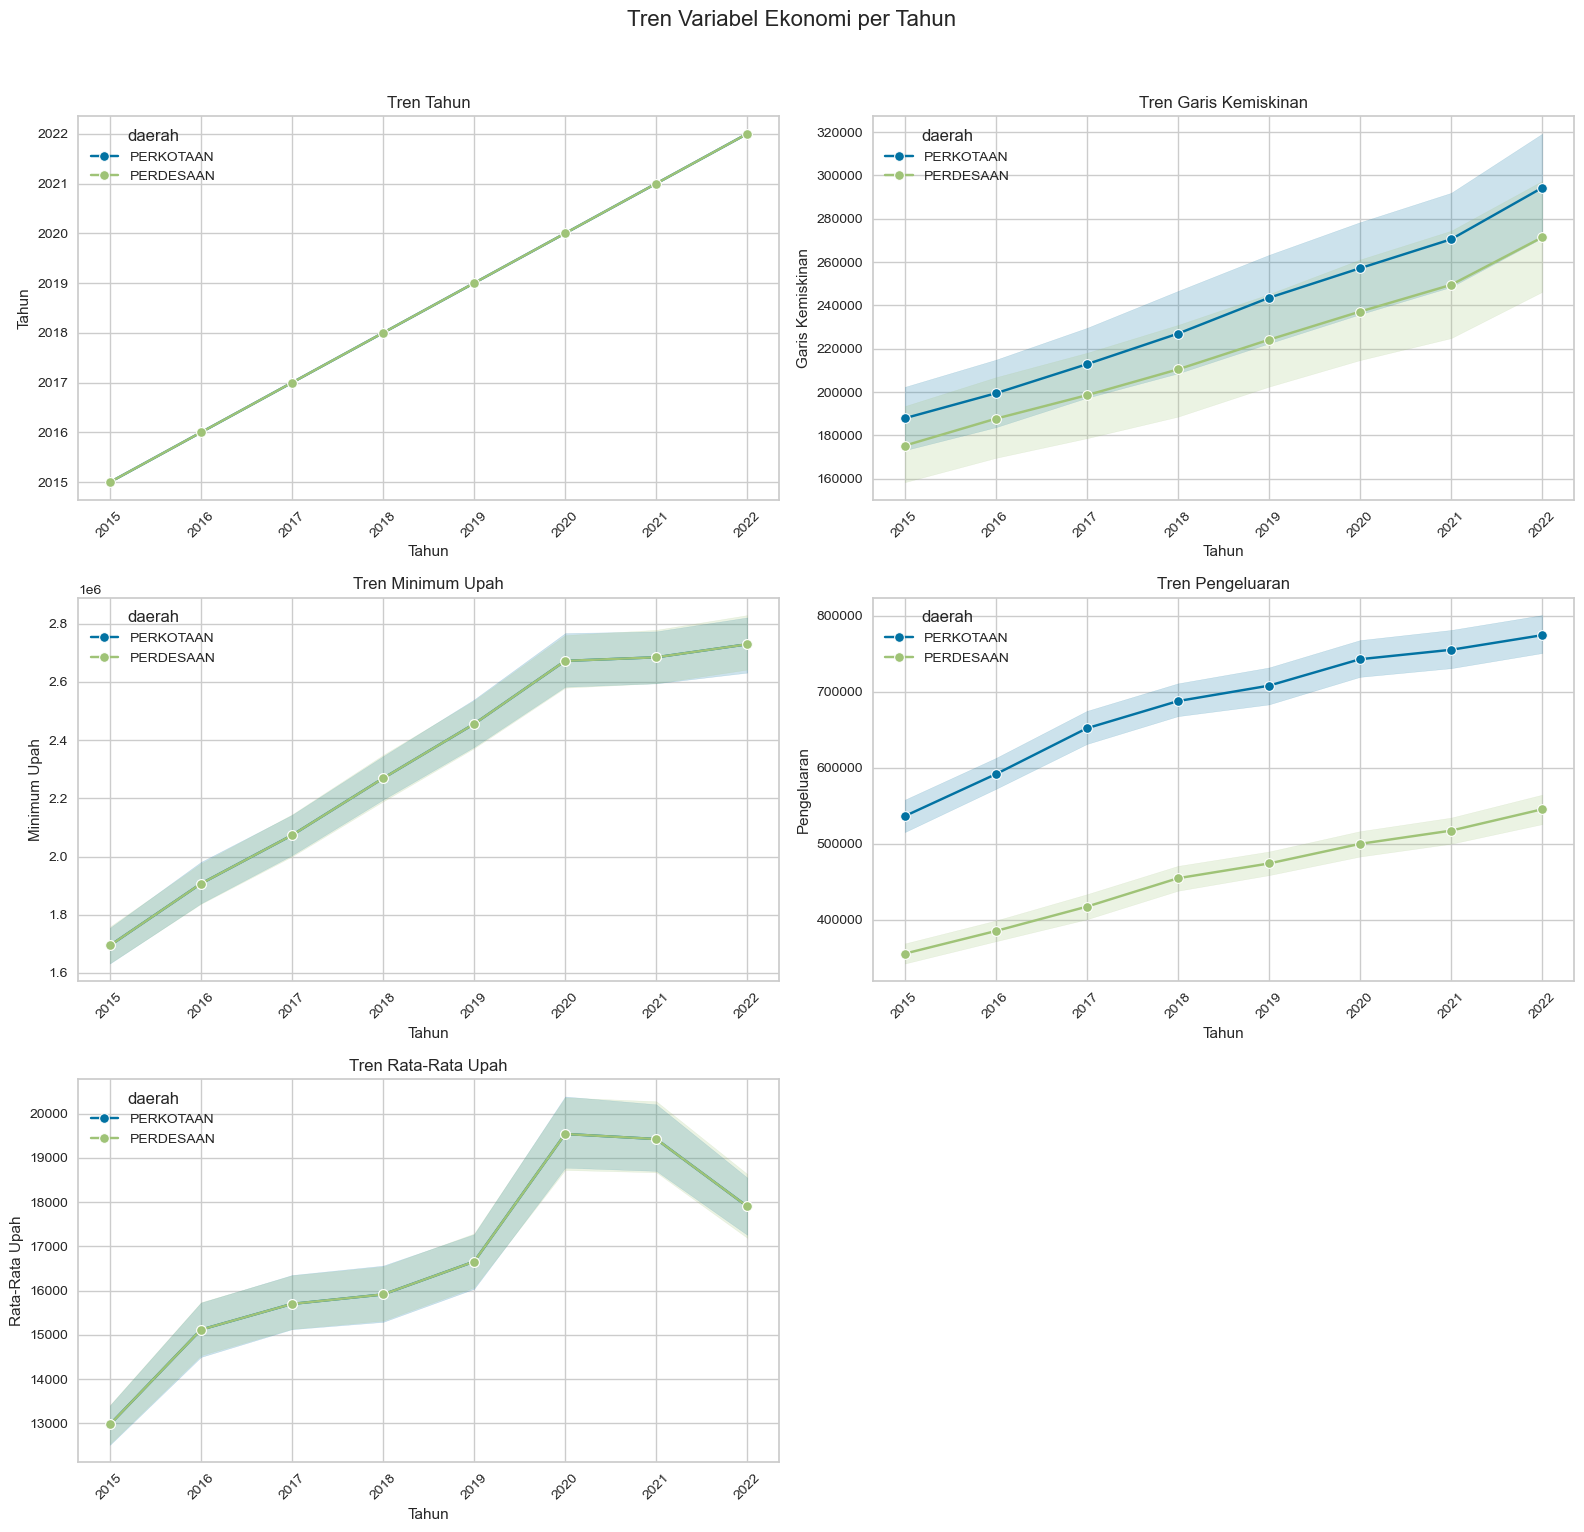

In [18]:
numeric_columns = merged_data.select_dtypes(include=[np.number]).columns.tolist()

num_cols = len(numeric_columns)
n_rows = (num_cols + 1) // 2 

plt.figure(figsize=(16, 5 * n_rows))
plt.suptitle("Tren Variabel Ekonomi per Tahun", fontsize=16, y=1.02)

for i, col in enumerate(numeric_columns):
    plt.subplot(n_rows, 2, i + 1)

    # plot
    if "daerah" in merged_data.columns and merged_data["daerah"].nunique() <= 10:
        sns.lineplot(data=merged_data, x="tahun", y=col, hue="daerah", marker="o")
    else:
        sns.lineplot(data=merged_data, x="tahun", y=col, marker="o")

    # nama label
    column_name = {
        "tahun": "Tahun",
        "gk": "Garis Kemiskinan",
        "ump": "Minimum Upah",
        "peng": "Pengeluaran",
        "upah": "Rata-Rata Upah"
    }.get(col, col)

    plt.title(f"Tren {column_name}")
    plt.xlabel("Tahun")
    plt.ylabel(column_name)
    plt.grid(True)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



---

### 📋 Tabel 1: **Penjelasan Setiap Grafik Tren Variabel**

| No | Variabel            | Penjelasan Detail                                                                                                                                      |
|----|---------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------|
| 1  | **Tahun**           | Grafik ini hanya menampilkan keberadaan data dari 2015–2022. Tidak memberikan insight signifikan, hanya untuk menegaskan kelengkapan data per tahun.  |
| 2  | **Garis Kemiskinan**| Terjadi kenaikan signifikan setiap tahun di kedua wilayah. Nilai di **Perkotaan selalu lebih tinggi** daripada Pedesaan. Selisih antar daerah membesar. |
| 3  | **Minimum Upah**    | Naik stabil dari 2015 hingga 2020, lalu **stagnan** hingga 2022. Perkotaan sedikit lebih tinggi, tapi tren antara daerah hampir paralel.               |
| 4  | **Pengeluaran**     | Konsisten meningkat setiap tahun. **Pengeluaran Perkotaan jauh lebih tinggi**, mencerminkan biaya hidup atau konsumsi yang lebih besar.                 |
| 5  | **Rata-Rata Upah**  | Meningkat hingga 2020, lalu **turun tajam** di 2021–2022. Pola sama di kedua wilayah. Kemungkinan besar dipengaruhi oleh **pandemi COVID-19**.         |

---

### 💡 Tabel 2: **Insight Utama dari Visualisasi**

| No | Insight                                                                                         | Penjelasan                                                                                         |
|----|--------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------|
| 1  | **Kesenjangan Wilayah**                                                                         | Semua variabel menunjukkan Perkotaan > Pedesaan. Ini menandakan ketimpangan ekonomi antar wilayah. |
| 2  | **Pertumbuhan Positif hingga 2020**                                                              | Hampir semua indikator meningkat stabil dari 2015 sampai 2020, mencerminkan pertumbuhan ekonomi.    |
| 3  | **Dampak Pandemi**                                                                              | Penurunan pada rata-rata upah setelah 2020 menunjukkan krisis ekonomi akibat pandemi.              |
| 4  | **Pengeluaran tetap naik meski pendapatan stagnan/menurun**                                     | Bisa menandakan tekanan ekonomi rumah tangga, terutama pasca pandemi.                              |
| 5  | **Perkotaan memiliki biaya hidup dan pendapatan lebih tinggi**                                  | Terlihat dari tren pengeluaran, garis kemiskinan, dan upah yang selalu lebih tinggi di perkotaan.  |

---

# **5. Data Preprocessing**

Pada tahap ini, data preprocessing adalah langkah penting untuk memastikan kualitas data sebelum digunakan dalam model machine learning. Data mentah sering kali mengandung nilai kosong, duplikasi, atau rentang nilai yang tidak konsisten, yang dapat memengaruhi kinerja model. Oleh karena itu, proses ini bertujuan untuk membersihkan dan mempersiapkan data agar analisis berjalan optimal.

Berikut adalah tahapan-tahapan yang bisa dilakukan, tetapi **tidak terbatas** pada:
1. Menghapus atau Menangani Data Kosong (Missing Values)
2. Menghapus Data Duplikat
3. Normalisasi atau Standarisasi Fitur
4. Deteksi dan Penanganan Outlier
5. Encoding Data Kategorikal
6. Binning (Pengelompokan Data)

Cukup sesuaikan dengan karakteristik data yang kamu gunakan yah.

## **1. MENGHAPUS ATAU MENANGANI DATA KOSONG (MISSING VALUES)**

In [19]:
merged_data.isna().sum()

provinsi     0
jenis        0
daerah       0
tahun        0
periode      0
gk          32
ump          0
peng        32
upah         0
dtype: int64

- Kolom **`provinsi`**, **`jenis`**, **`daerah`**, **`tahun`**, **`periode`**, **`ump`**, dan **`upah`** tidak memiliki nilai kosong (semua datanya lengkap).
- Kolom **`gk`** dan **`peng`** masing-masing memiliki **32 nilai kosong (NaN)**.
---

In [20]:
for i in ["gk", "peng"]:
    merged_data[i] = merged_data[i].interpolate(method="linear")

merged_data.isna().sum()

provinsi    0
jenis       0
daerah      0
tahun       0
periode     0
gk          0
ump         0
peng        0
upah        0
dtype: int64

- Semua kolom kini **tidak memiliki nilai kosong**.
- Kolom `gk` dan `peng` yang sebelumnya memiliki 32 nilai NaN, sekarang **sudah terisi sepenuhnya** dengan metode interpolasi linier.

---

## **2. MENGHAPUS DATA DUPLIKAT**

In [21]:
jumlah_duplikat = merged_data.duplicated().sum()
print("="*40)
print("🔍 Deteksi Duplikat Data")
print("="*40)
print(f"Jumlah data ganda (duplikat) pada dataset: {jumlah_duplikat}")
print("="*40)


🔍 Deteksi Duplikat Data
Jumlah data ganda (duplikat) pada dataset: 0


**Tidak ada duplicated data pada dataset**

---

## **3. NORMALISASI ATAU STANDARISASI FITUR**

In [22]:
merged_data.head()

,provinsi,jenis,daerah,tahun,periode,gk,ump,peng,upah
0,ACEH,MAKANAN,PERKOTAAN,2015,MARET,293697.0,1900000.0,466355.0,11226
1,ACEH,MAKANAN,PERKOTAAN,2015,SEPTEMBER,302128.0,1900000.0,466355.0,11226
2,ACEH,MAKANAN,PERDESAAN,2015,MARET,297479.0,1900000.0,395136.0,11226
3,ACEH,MAKANAN,PERDESAAN,2015,SEPTEMBER,306737.0,1900000.0,395136.0,11226
4,ACEH,NONMAKANAN,PERKOTAAN,2015,MARET,116717.0,1900000.0,529945.0,11226


In [23]:
from sklearn.preprocessing import MinMaxScaler

normalized_df = merged_data.copy()
scaler = MinMaxScaler()

columns_to_normalize = numeric_columns[1:]

normalized_df[columns_to_normalize] = scaler.fit_transform(normalized_df[columns_to_normalize])
normalized_df.head()


,provinsi,jenis,daerah,tahun,periode,gk,ump,peng,upah
0,ACEH,MAKANAN,PERKOTAAN,2015,MARET,0.413212,0.265284,0.207971,0.111796
1,ACEH,MAKANAN,PERKOTAAN,2015,SEPTEMBER,0.427424,0.265284,0.207971,0.111796
2,ACEH,MAKANAN,PERDESAAN,2015,MARET,0.419587,0.265284,0.156954,0.111796
3,ACEH,MAKANAN,PERDESAAN,2015,SEPTEMBER,0.435193,0.265284,0.156954,0.111796
4,ACEH,NONMAKANAN,PERKOTAAN,2015,MARET,0.114887,0.265284,0.253523,0.111796


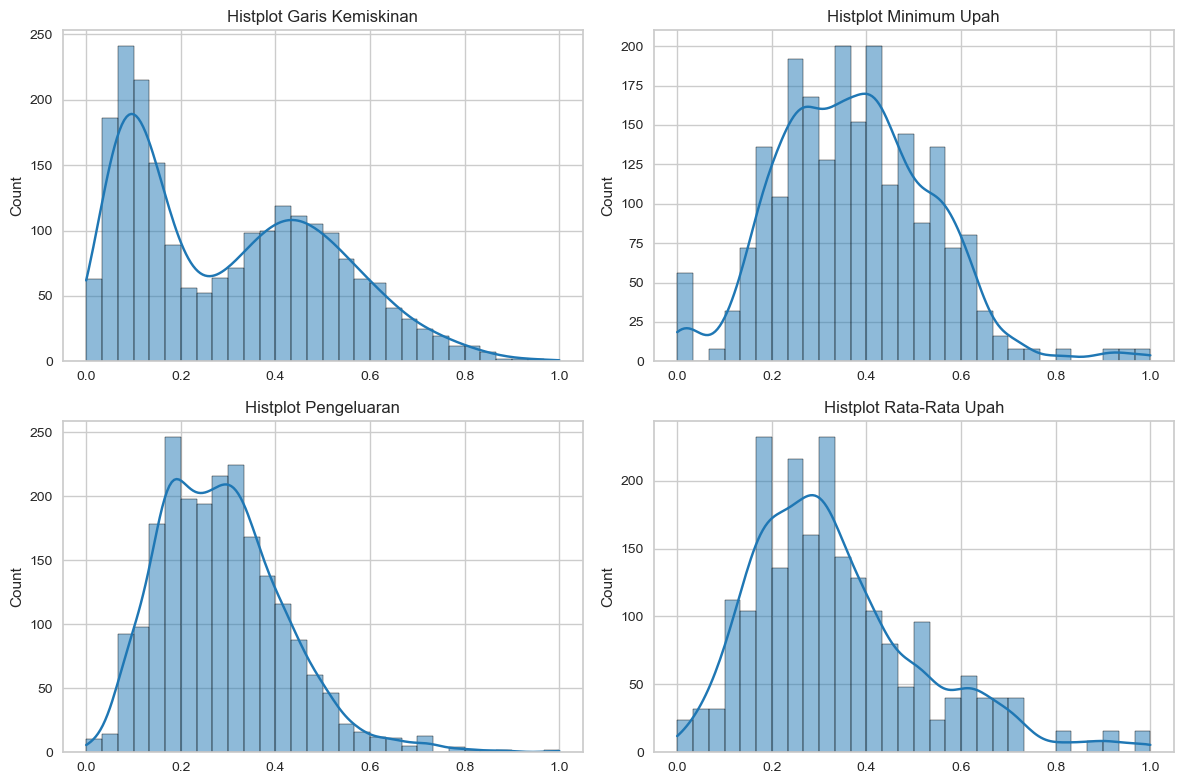

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Mapping nama kolom ke label yang lebih deskriptif
column_labels = {
    "gk": "Garis Kemiskinan",
    "ump": "Minimum Upah",
    "peng": "Pengeluaran",
    "upah": "Rata-Rata Upah"
}

plt.figure(figsize=(12, 8))

for i, col in enumerate(numeric_columns[1:], 1):
    plt.subplot(2, 2, i)
    sns.histplot(x=normalized_df[col], bins=30, kde=True, color="tab:blue")

    column_name = column_labels.get(col, col)  # Gunakan nama asli jika tidak ada di dictionary

    plt.title(f"Histplot {column_name}")
    plt.xlabel(None)

plt.tight_layout()
plt.show()

### 📊 **Insight Distribusi Data Setelah Normalisasi**

| No | Variabel            | Pola Distribusi     | Insight Utama                                                                                                                                  |
|----|---------------------|---------------------|-------------------------------------------------------------------------------------------------------------------------------------------------|
| 1  | Garis Kemiskinan    | Right-skewed        | Mayoritas memiliki nilai rendah setelah normalisasi; hanya sedikit daerah dengan garis kemiskinan yang tinggi.                                 |
| 2  | Minimum Upah        | Mendekati Normal    | Nilai minimum upah tersebar relatif merata, menunjukkan adanya keseimbangan antar wilayah dalam regulasi upah minimum.                         |
| 3  | Pengeluaran         | Right-skewed        | Sebagian besar penduduk mengeluarkan dana dalam jumlah rendah; pengeluaran besar hanya dimiliki oleh sebagian kecil populasi.                  |
| 4  | Rata-Rata Upah      | Hampir Normal (Right-Skewed) | Mayoritas penduduk memiliki upah di bawah rata-rata; hanya sebagian kecil dengan upah tinggi.                                   |

---

### 📌 **Kesimpulan Umum**
- Tiga dari empat variabel menunjukkan distribusi **condong ke kanan** (right-skewed), mengindikasikan **ketimpangan** dalam distribusi ekonomi.
- Hanya **Minimum Upah** yang memiliki distribusi relatif merata, kemungkinan karena regulasi pemerintah yang lebih konsisten antar daerah.
- Insight ini bisa menjadi dasar untuk analisis lebih lanjut seperti:
  - Deteksi wilayah dengan risiko ekonomi tinggi
  - Klasifikasi kesejahteraan masyarakat
  - Visualisasi korelasi antar variabel

---

## **4. DETEKSI DAN PENANGANAN OUTLIER**

In [25]:
def get_iqr_bounds(df, column):
    q1, q3 = df[column].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return lower_bound, upper_bound


def detect_outliers_iqr(df, column):
    lower_bound, upper_bound = get_iqr_bounds(df, column)
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]


def clip_outliers_iqr(df, column):
    lower_bound, upper_bound = get_iqr_bounds(df, column)
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df


In [26]:
outlier_counts = {
    col: len(detect_outliers_iqr(normalized_df, col))
    for col in numeric_columns[1:]
}

# tampilkan hasil deteksi outlier
print("Jumlah Outliers per Kolom:")
for col, count in outlier_counts.items():
    print(f"- {col}: {count}")


Jumlah Outliers per Kolom:
- gk: 0
- ump: 32
- peng: 40
- upah: 56


### **1️⃣ Deteksi Outlier (Sebelum Penanganan)**

Menggunakan metode **Interquartile Range (IQR)**, jumlah outlier pada setiap kolom numerik adalah sebagai berikut:

| Kolom              | Jumlah Outlier |
|--------------------|----------------|
| Garis Kemiskinan (`gk`) | 0              |
| Minimum Upah (`ump`)     | 32             |
| Pengeluaran (`peng`)     | 40             |
| Rata-Rata Upah (`upah`)  | 56             |

🔍 *Insight:* Kolom `upah` merupakan kolom dengan outlier terbanyak, diikuti oleh `peng` dan `ump`. Sementara kolom `gk` relatif bersih dari outlier.

---

In [27]:
# proses clipping outlier untuk setiap kolom numerik (kecuali kolom pertama)
for col in numeric_columns[1:]:
    normalized_df = clip_outliers_iqr(normalized_df, col)

# deteksi kembali jumlah outlier setelah proses clipping
outlier_counts_after_clip = {
    col: len(detect_outliers_iqr(normalized_df, col))
    for col in numeric_columns[1:]
}

# tampilkan hasil deteksi outlier setelah clipping
print("Jumlah Outliers setelah di-clip:")
for col, count in outlier_counts_after_clip.items():
    print(f"- {col}: {count}")


Jumlah Outliers setelah di-clip:
- gk: 0
- ump: 0
- peng: 0
- upah: 0


### **2️⃣ Penanganan Outlier**

Outlier ditangani menggunakan **clipping berbasis IQR**, yaitu nilai-nilai di luar batas bawah dan atas digantikan dengan nilai batas tersebut.

#### ✅ Jumlah Outlier Setelah Clipping

| Kolom              | Outlier Setelah Clipping |
|--------------------|--------------------------|
| Garis Kemiskinan (`gk`) | 0                        |
| Minimum Upah (`ump`)     | 0                        |
| Pengeluaran (`peng`)     | 0                        |
| Rata-Rata Upah (`upah`)  | 0                        |

📌 *Hasil:* Semua nilai ekstrim berhasil ditangani tanpa perlu menghapus data, sehingga dataset tetap utuh dan bersih.

---

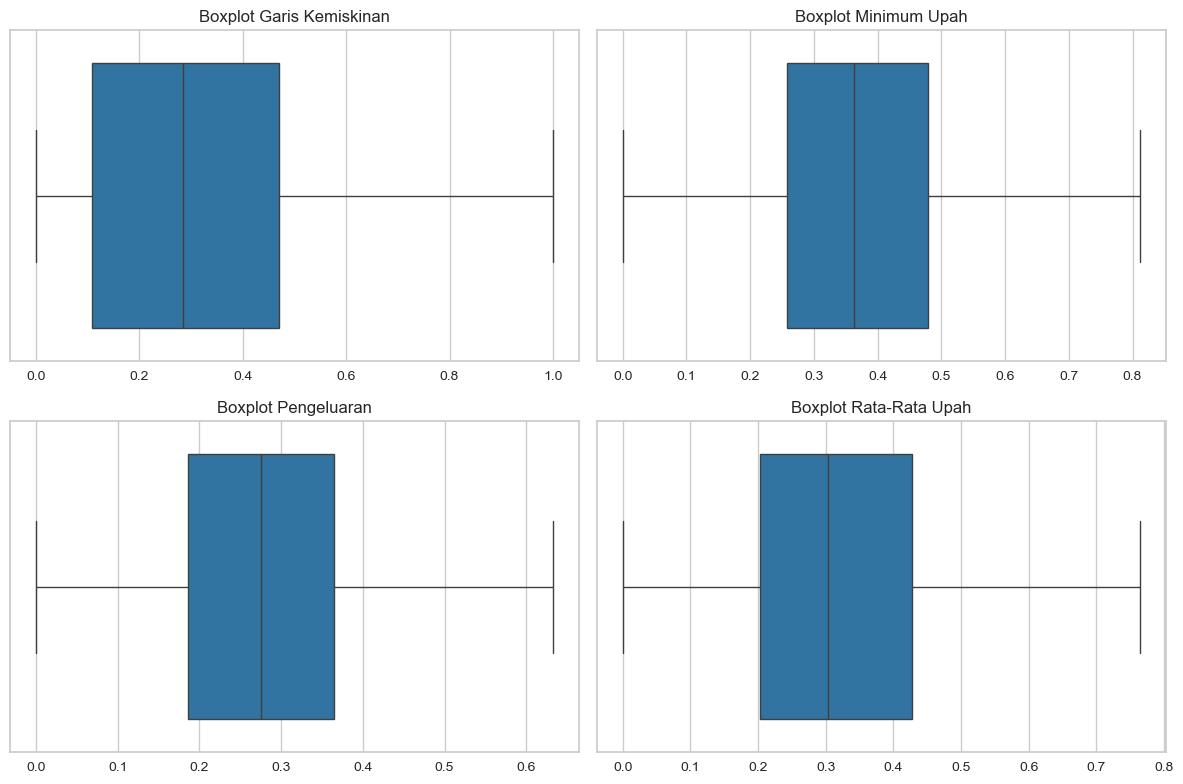

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# mapping nama kolom ke label yang lebih deskriptif
column_labels = {
    "gk": "Garis Kemiskinan",
    "ump": "Minimum Upah",
    "peng": "Pengeluaran",
    "upah": "Rata-Rata Upah"
}

# ukuran figure
plt.figure(figsize=(12, 8))

# Loop untuk membuat subplot boxplot
for i, col in enumerate(numeric_columns[1:], 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=normalized_df[col], color="tab:blue")

    # Ambil nama kolom deskriptif, fallback ke nama asli jika tidak ada di mapping
    column_name = column_labels.get(col, col)
    
    plt.title(f"Boxplot {column_name}")
    plt.xlabel("")  

plt.tight_layout()
plt.show()


📊 **Penjelasan Visualisasi:**
- Setiap subplot menunjukkan distribusi dari masing-masing kolom setelah proses normalisasi dan clipping.
- Tidak ada lagi titik outlier yang terlihat pada visualisasi boxplot.
- Distribusi terlihat lebih simetris dan berada dalam rentang yang wajar.
- Median berada di tengah kotak, menandakan tidak ada skew yang ekstrem setelah pembersihan data.

---

**🔚 Kesimpulan**

- Metode IQR sangat efektif dalam mendeteksi outlier pada data numerik.
- Proses **clipping** menjaga integritas data (tidak menghapus baris) namun tetap menghilangkan pengaruh nilai-nilai ekstrim.
- Hasil visualisasi mendukung keberhasilan proses ini, yang penting untuk mencegah bias dalam proses analisis lanjutan atau pemodelan.

---

## **5. ENCODING DATA KATEGORIKAL**

In [29]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

encoder = OneHotEncoder(sparse_output=False, drop="first")
categorical_columns = ["jenis", "daerah"]
encoded_array = encoder.fit_transform(normalized_df[categorical_columns])
encoded_column_names = [col.lower() for col in encoder.get_feature_names_out(categorical_columns)]
encoded_df = pd.DataFrame(encoded_array, columns=encoded_column_names, index=normalized_df.index)
normalized_df = pd.concat([normalized_df, encoded_df], axis=1)

normalized_df.head()


,provinsi,jenis,daerah,tahun,periode,gk,ump,peng,upah,jenis_nonmakanan,daerah_perkotaan
0,ACEH,MAKANAN,PERKOTAAN,2015,MARET,0.413212,0.265284,0.207971,0.111796,0.0,1.0
1,ACEH,MAKANAN,PERKOTAAN,2015,SEPTEMBER,0.427424,0.265284,0.207971,0.111796,0.0,1.0
2,ACEH,MAKANAN,PERDESAAN,2015,MARET,0.419587,0.265284,0.156954,0.111796,0.0,0.0
3,ACEH,MAKANAN,PERDESAAN,2015,SEPTEMBER,0.435193,0.265284,0.156954,0.111796,0.0,0.0
4,ACEH,NONMAKANAN,PERKOTAAN,2015,MARET,0.114887,0.265284,0.253523,0.111796,1.0,1.0


**Saya melakukan proses one-hot encoding untuk mengubah kolom kategorikal `jenis` dan `daerah` menjadi bentuk numerik agar dapat digunakan dalam pemodelan machine learning. Saya menggunakan teknik encoding dengan menghapus satu kategori pertama dari masing-masing kolom untuk menghindari masalah multikolinearitas. Setelah proses ini, kolom hasil encoding ditambahkan ke dalam dataset utama sehingga siap digunakan untuk analisis lebih lanjut.**

---

# **6. Pembangunan Model Clustering**

## **a. Pembangunan Model Clustering**

Pada tahap ini, Anda membangun model clustering dengan memilih algoritma yang sesuai untuk mengelompokkan data berdasarkan kesamaan. Berikut adalah **rekomendasi** tahapannya.
1. Pilih algoritma clustering yang sesuai.
2. Latih model dengan data menggunakan algoritma tersebut.

In [30]:
processed_df = normalized_df.copy()
features = processed_df.select_dtypes(include=np.number).columns[1:]

processed_df.head()

,provinsi,jenis,daerah,tahun,periode,gk,ump,peng,upah,jenis_nonmakanan,daerah_perkotaan
0,ACEH,MAKANAN,PERKOTAAN,2015,MARET,0.413212,0.265284,0.207971,0.111796,0.0,1.0
1,ACEH,MAKANAN,PERKOTAAN,2015,SEPTEMBER,0.427424,0.265284,0.207971,0.111796,0.0,1.0
2,ACEH,MAKANAN,PERDESAAN,2015,MARET,0.419587,0.265284,0.156954,0.111796,0.0,0.0
3,ACEH,MAKANAN,PERDESAAN,2015,SEPTEMBER,0.435193,0.265284,0.156954,0.111796,0.0,0.0
4,ACEH,NONMAKANAN,PERKOTAAN,2015,MARET,0.114887,0.265284,0.253523,0.111796,1.0,1.0


In [31]:
k_range = range(2, 11)
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(processed_df[features])
    
    score = silhouette_score(processed_df[features], cluster_labels)
    silhouette_scores.append(score)

In [32]:
best_k = k_range[silhouette_scores.index(max(silhouette_scores))]
best_score = max(silhouette_scores)

print(f"Silhouette Score terbaik untuk KMeans: {best_score:.4f}")
print(f"Jumlah kluster optimal untuk KMeans: {best_k}")

Silhouette Score terbaik untuk KMeans: 0.6891
Jumlah kluster optimal untuk KMeans: 4


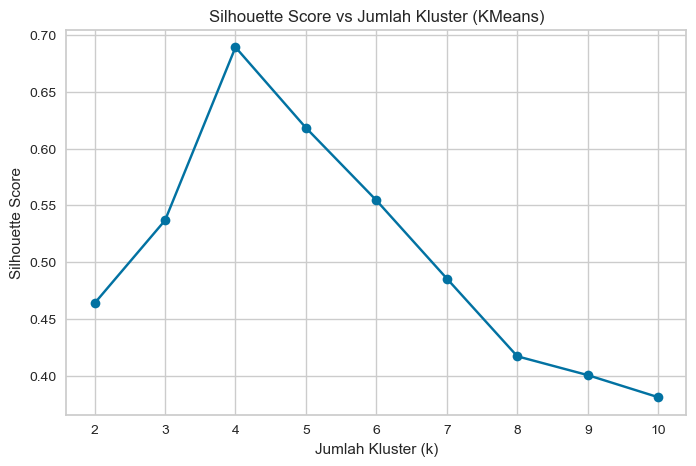

In [33]:
plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Silhouette Score vs Jumlah Kluster (KMeans)')
plt.xlabel('Jumlah Kluster (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()


## 📊 **Hasil Analisis Clustering dengan KMeans**

### 🔹 1. Jumlah Kluster Optimal: **4**
- Berdasarkan evaluasi dengan *silhouette score*, jumlah kluster terbaik adalah **4**.
- Hal ini ditunjukkan oleh nilai **silhouette tertinggi sebesar 0.6891** pada saat `k = 4`.

---

### 🔹 2. Interpretasi Silhouette Score

| Rentang Nilai     | Interpretasi                      |
|-------------------|-----------------------------------|
| 0.70 – 1.00       | Kluster sangat baik               |
| **0.50 – 0.70**   | **Kluster cukup baik (✅)**        |
| 0.25 – 0.50       | Struktur kluster lemah            |
| < 0.25            | Tidak ada struktur kluster        |

- Nilai **0.6891** menandakan kluster yang **terpisah dengan baik** dan **koheren secara internal**.
- Artinya, objek dalam satu kluster cenderung **mirip satu sama lain** dan **berbeda dengan objek di kluster lain**.

---

### 🔹 3. Visualisasi: Silhouette Score vs Jumlah Kluster

📌 Dari grafik:
- Terlihat **peningkatan signifikan hingga k = 4**, lalu menurun tajam setelahnya.
- Hal ini menunjukkan bahwa menambah jumlah kluster **tidak meningkatkan performa**, malah memperburuk struktur kluster.

---

### 🔹 4. Rekomendasi & Langkah Lanjutan

✅ **Gunakan 4 kluster** untuk pemodelan akhir.  
Selanjutnya, kamu bisa:

1. **Menambahkan label kluster** ke dalam dataset:
   - Untuk analisis karakteristik masing-masing grup.
2. **Visualisasi kluster 2D**:
   - Gunakan metode seperti PCA atau TSNE.
3. **Analisis masing-masing kluster**:
   - Cek perbedaan antar kluster berdasarkan fitur seperti daya listrik, jumlah perangkat, penghasilan, dll.

---

## **b. Evaluasi Model Clustering**

Untuk menentukan jumlah cluster yang optimal dalam model clustering, Anda dapat menggunakan metode Elbow atau Silhouette Score.

Metode ini membantu kita menemukan jumlah cluster yang memberikan pemisahan terbaik antar kelompok data, sehingga model yang dibangun dapat lebih efektif. Berikut adalah **rekomendasi** tahapannya.
1. Gunakan Silhouette Score dan Elbow Method untuk menentukan jumlah cluster optimal.
2. Hitung Silhouette Score sebagai ukuran kualitas cluster.

🔍 Menentukan nilai k optimal menggunakan Elbow Method...

✅ Nilai optimal k berdasarkan Elbow Method: 4



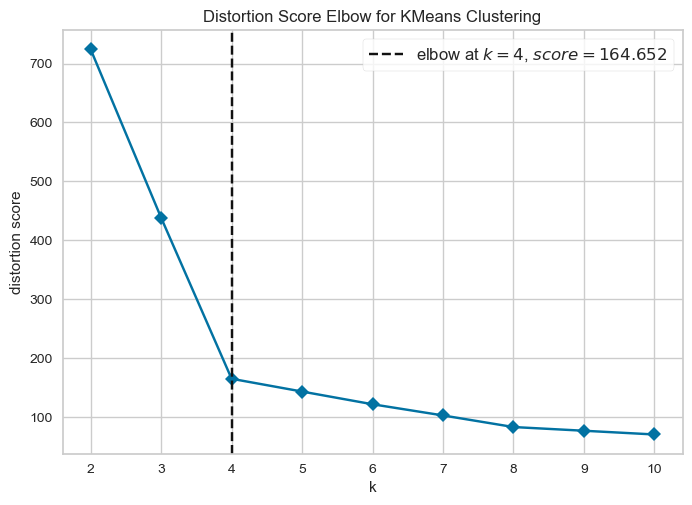

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [45]:
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# --- 1. Menentukan nilai k optimal dengan Elbow Method ---
print("🔍 Menentukan nilai k optimal menggunakan Elbow Method...\n")

# Inisialisasi model KMeans
kmeans_model = KMeans(random_state=42, n_init=10)

# Range jumlah kluster yang diuji
k_range = range(2, 11)

# Visualisasi Elbow
elbow_visualizer = KElbowVisualizer(kmeans_model, k=k_range, timings=False)
elbow_visualizer.fit(processed_df[features])

# Ambil nilai k terbaik dari elbow
optimal_k = elbow_visualizer.elbow_value_
print(f"✅ Nilai optimal k berdasarkan Elbow Method: {optimal_k}\n")

# Tampilkan plot elbow
elbow_visualizer.show()

### 📈 1. **Elbow Method — Menentukan Nilai k Optimal**
#### 🔍 Penjelasan:
- Grafik menunjukkan **distortion score (inertia)** pada sumbu Y terhadap jumlah kluster `k` di sumbu X.
- Distortion = seberapa jauh titik-titik dari pusat kluster mereka (semakin kecil, semakin baik).
- Ada “tekukan” (elbow) di **k = 4**, yang menunjukkan bahwa menambahkan lebih banyak kluster setelah titik ini **tidak mengurangi distortion secara signifikan**.

### ✅ Insight:
- **Nilai optimal k = 4**, karena di titik inilah terdapat perubahan terbesar sebelum laju penurunan melambat drastis.
- Ini artinya data kamu secara alami terbagi menjadi 4 kluster yang berbeda.

---

🔍 Menampilkan visualisasi Silhouette Score...

✅ Nilai Silhouette Score untuk k=4: 0.6891



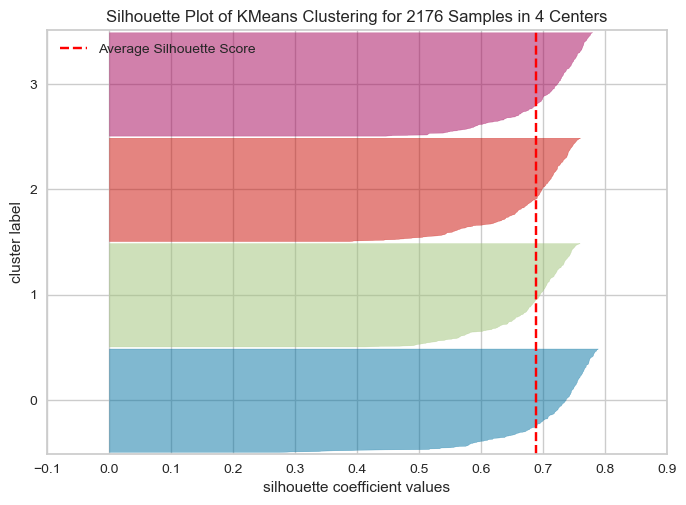

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 2176 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [49]:
print("🔍 Menampilkan visualisasi Silhouette Score...\n")

kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)

silhouette_visualizer = SilhouetteVisualizer(kmeans_optimal, colors='yellowbrick')
silhouette_visualizer.fit(processed_df[features])

score = silhouette_visualizer.silhouette_score_
print(f"✅ Nilai Silhouette Score untuk k={optimal_k}: {score:.4f}\n")

silhouette_visualizer.show()

### 📊 2. **Silhouette Score — Menilai Kualitas Kluster**
#### 🔍 Penjelasan:
- Visualisasi ini memperlihatkan **distribusi nilai silhouette untuk setiap kluster**.
- Silhouette coefficient mengukur **seberapa mirip objek dengan klusternya sendiri dibandingkan dengan kluster lain**.
- Skor berkisar antara -1 (buruk) hingga +1 (baik).
- Garis putus merah menunjukkan **rata-rata silhouette score**.

### ✅ Insight:
- **Nilai silhouette score = 0.6891**, yang tergolong **baik** (di atas 0.5).
- Ini menunjukkan bahwa mayoritas data dikelompokkan dengan baik dan kluster saling terpisah dengan jelas.
- Kluster terlihat **seimbang** dan tidak ada yang terlalu kecil atau terlalu tumpang tindih.

---


## 🎯 Kesimpulan Akhir

| Aspek                      | Hasil                                                                 |
|---------------------------|-----------------------------------------------------------------------|
| 🔢 Jumlah Kluster Optimal  | **4**, berdasarkan Elbow Method                                       |
| 📈 Silhouette Score        | **0.6891**, menunjukkan kualitas clustering yang **baik**             |
| 🔍 Data yang Digunakan     | **Data asli yang telah dinormalisasi** (tanpa PCA)                   |
| ✅ Keputusan Model         | Lanjutkan model clustering dengan **KMeans dan k=4**                 |

---

## **c. Feature Selection (Opsional)**

Silakan lakukan feature selection jika Anda membutuhkan optimasi model clustering. Jika Anda menerapkan proses ini, silakan lakukan pemodelan dan evaluasi kembali menggunakan kolom-kolom hasil feature selection. Terakhir, bandingkan hasil performa model sebelum dan sesudah menerapkan feature selection.

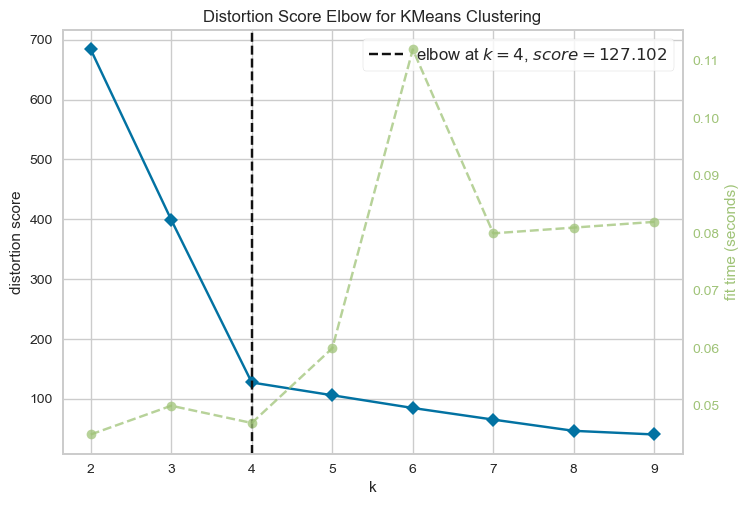

In [53]:
# Mendefinisikan PCA
pca = PCA(n_components= 0.95 , random_state=42)
pca_df = pca.fit_transform(processed_df[features])

# Menentukan Jumlah Cluster Optimal dengan Elbow Method
kmeans_optimal2 = KMeans(random_state=42)
visualizer = KElbowVisualizer(kmeans_optimal2, k=(2, 10))
visualizer.fit(pca_df)
visualizer.show()

k_optimal = visualizer.elbow_value_

In [55]:
kmeans_optimal3 = KMeans(n_clusters=visualizer.elbow_value_, random_state=42)
kmeans_optimal3.fit(pca_df)

# Hitung Silhouette Score
silhouette_avg_optimal_2 = silhouette_score(pca_df, kmeans_optimal3.labels_)

# Menampilkan hasil
print(f"Jumlah cluster optimal: {visualizer.elbow_value_}")
print(f"Silhouette Score (dengan PCA): {silhouette_avg_optimal_2:.4f}")

Jumlah cluster optimal: 4
Silhouette Score (dengan PCA): 0.7440


### **Penjelasan**:
Penerapan **Principal Component Analysis (PCA)** terbukti memberikan dampak positif terhadap hasil clustering. Hal ini terlihat dari peningkatan **Silhouette Score**, yaitu metrik yang digunakan untuk mengukur seberapa baik objek-objek dikelompokkan dalam klaster yang sesuai.

- **Silhouette Score sebelum PCA**: 0.69  
- **Silhouette Score setelah PCA**: 0.74

Peningkatan skor ini menunjukkan bahwa hasil klasterisasi setelah penerapan PCA menjadi lebih optimal, di mana pemisahan antar klaster semakin jelas dan kekompakan dalam setiap klaster menjadi lebih baik. Dengan kata lain, PCA berhasil mereduksi dimensi data tanpa menghilangkan informasi penting, sekaligus meningkatkan kualitas pemodelan clustering secara keseluruhan.

---

## **d. Visualisasi Hasil Clustering**

Setelah model clustering dilatih dan jumlah cluster optimal ditentukan, langkah selanjutnya adalah menampilkan hasil clustering melalui visualisasi.

Berikut adalah **rekomendasi** tahapannya.
1. Tampilkan hasil clustering dalam bentuk visualisasi, seperti grafik scatter plot atau 2D PCA projection.

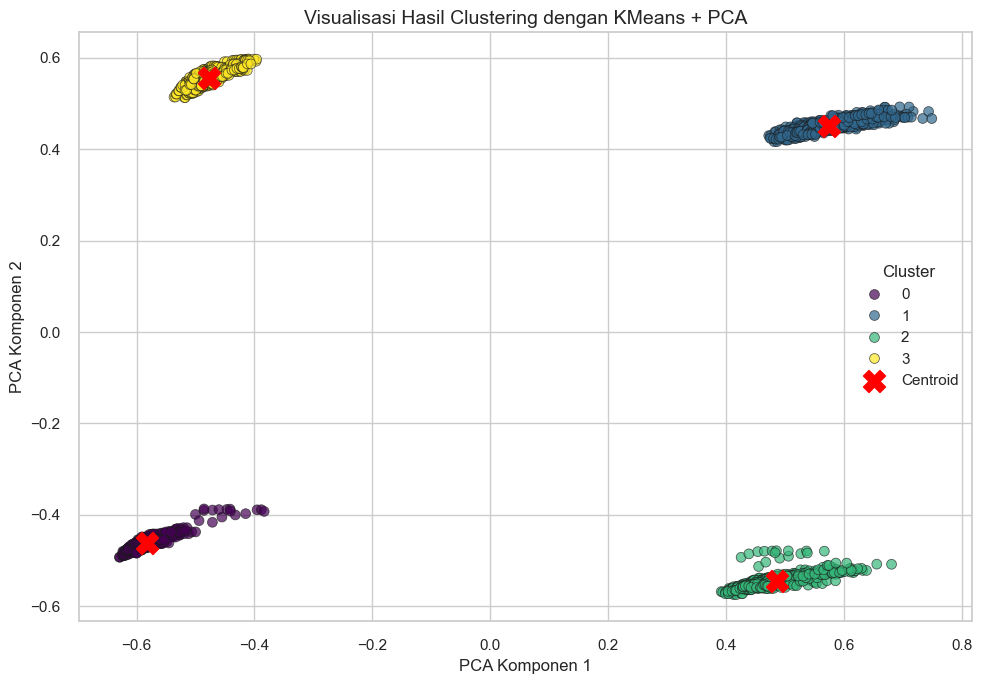

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

centroids_2d = kmeans_optimal3.cluster_centers_[:, :2]

# Buat visualisasi hasil clustering
plt.figure(figsize=(10, 7))
sns.set(style="whitegrid")

# Scatter plot untuk setiap titik hasil PCA dan clustering
sns.scatterplot(
    x=pca_df[:, 0],
    y=pca_df[:, 1],
    hue=kmeans_optimal3.labels_,
    palette="viridis",
    s=50,
    edgecolor="k",
    alpha=0.7
)

# Plot centroid dengan tanda khusus
plt.scatter(
    centroids_2d[:, 0],
    centroids_2d[:, 1],
    marker="X",
    s=250,
    c="red",
    label="Centroid"
)

# Tambahkan judul dan label
plt.title("Visualisasi Hasil Clustering dengan KMeans + PCA", fontsize=14)
plt.xlabel("PCA Komponen 1", fontsize=12)
plt.ylabel("PCA Komponen 2", fontsize=12)
plt.legend(title="Cluster", loc="best")
plt.tight_layout()
plt.show()


### **1. Visualisasi dengan PCA**

**🔍 Penjelasan:**
- **Metode Reduksi Dimensi**: Principal Component Analysis (PCA) digunakan untuk mereduksi data ke dalam 2 dimensi utama, yaitu *PCA Komponen 1* dan *PCA Komponen 2*.
- **Plot**: Setiap titik merepresentasikan data yang telah direduksi, dan diwarnai berdasarkan hasil cluster KMeans.
- **Centroid**: Titik centroid dari setiap klaster ditampilkan dengan simbol “X” besar berwarna merah.

**🧠 Interpretasi:**
- **Distribusi Klaster**: Terlihat bahwa data membentuk empat kelompok yang terpisah dengan sangat baik. Setiap klaster memiliki area yang jelas, tanpa tumpang tindih yang signifikan.
- **Jarak antar centroid**: Centroid dari masing-masing klaster cukup berjauhan satu sama lain, yang menunjukkan bahwa algoritma KMeans berhasil memisahkan kelompok berdasarkan fitur utama.
- **Kompak dan Terpisah**: Klaster-klaster cukup kompak (rapat) dan juga saling terpisah, ini merupakan indikator bahwa hasil clustering memiliki kualitas yang tinggi menurut metrik seperti *Silhouette Score*.

---

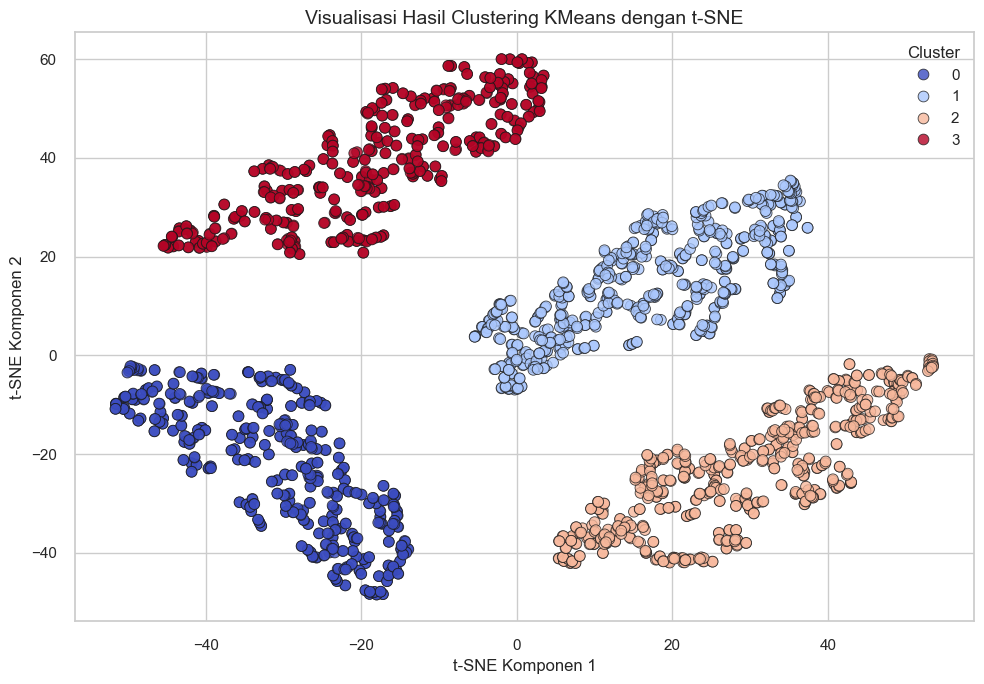

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Tambahkan label hasil clustering ke dalam data
processed_df["cluster"] = kmeans_optimal3.labels_

# Lakukan reduksi dimensi dengan t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(processed_df[features])

# Visualisasi hasil clustering dengan t-SNE
plt.figure(figsize=(10, 7))
sns.set(style="whitegrid")

sns.scatterplot(
    x=tsne_result[:, 0],
    y=tsne_result[:, 1],
    hue=processed_df["cluster"],
    palette="coolwarm",
    s=60,
    edgecolor="k",
    alpha=0.8
)

# Tambahkan judul dan label
plt.title("Visualisasi Hasil Clustering KMeans dengan t-SNE", fontsize=14)
plt.xlabel("t-SNE Komponen 1", fontsize=12)
plt.ylabel("t-SNE Komponen 2", fontsize=12)
plt.legend(title="Cluster", loc="best")
plt.tight_layout()
plt.show()


## **2. Visualisasi dengan t-SNE**

**🔍 Penjelasan:**
- **Metode Reduksi Dimensi**: t-distributed Stochastic Neighbor Embedding (t-SNE) digunakan untuk merepresentasikan data dalam 2 dimensi berdasarkan kemiripan lokal antar data.
- **Plot**: Titik-titik menunjukkan data yang telah direduksi, dan dibedakan berdasarkan klaster KMeans dengan warna berbeda.

**🧠 Interpretasi:**
- **Kejelasan Klaster**: Sama seperti pada PCA, t-SNE berhasil memisahkan data menjadi 4 klaster yang jelas dan terpisah dengan baik.
- **Struktur Non-Linear**: Tidak seperti PCA yang berbasis linear, t-SNE menangkap hubungan non-linear antar data. Pola distribusi klaster lebih organik dan mencerminkan struktur lokal yang lebih kompleks.
- **Jarak Antar Klaster**: Klaster-klaster terlihat lebih "tersebar bebas", namun tetap mempertahankan kohesivitas internal yang baik — artinya data dalam satu klaster tetap saling berdekatan.

---

### 🎯 **Kesimpulan Umum:**
- **Kedua visualisasi menunjukkan hasil clustering KMeans yang sangat baik**, dengan pemisahan antar klaster yang jelas dan terstruktur.
- **PCA** memberikan gambaran global mengenai distribusi data berdasarkan variasi terbesar.
- **t-SNE** memberikan representasi yang lebih mendalam tentang hubungan lokal antar data, meskipun tidak mempertahankan skala jarak global.
- Kombinasi keduanya memperkuat keyakinan bahwa model clustering sudah optimal dan hasil klaster dapat digunakan untuk segmentasi lebih lanjut, seperti analisis pelanggan, perilaku, atau strategi pemasaran.


---

## **e. Analisis dan Interpretasi Hasil Cluster**

### Interpretasi Target

**Tutorial: Melakukan Inverse Transform pada Data Target Setelah Clustering**

Setelah melakukan clustering dengan model **KMeans**, kita perlu mengembalikan data yang telah diubah (normalisasi, standarisasi, atau label encoding) ke bentuk aslinya. Berikut adalah langkah-langkahnya.

---

**1. Tambahkan Hasil Label Cluster ke DataFrame**
Setelah mendapatkan hasil clustering, kita tambahkan label cluster ke dalam DataFrame yang telah dinormalisasi.

```python
df_normalized['Cluster'] = model_kmeans.labels_
```

Lakukan Inverse Transform pada feature yang sudah dilakukan Labelisasi dan Standararisasi. Berikut code untuk melakukannya:
label_encoder.inverse_transform(X_Selected[['Fitur']])

Lalu masukkan ke dalam kolom dataset asli atau membuat dataframe baru
```python
df_normalized['Fitur'] = label_encoder.inverse_transform(df_normalized[['Fitur']])
```
Masukkan Data yang Sudah Di-Inverse ke dalam Dataset Asli atau Buat DataFrame Baru
```python
df_original['Fitur'] = df_normalized['Fitur']
```

In [59]:
normalized_df["cluster"] = processed_df["cluster"]
normalized_df.head()

,provinsi,jenis,daerah,tahun,periode,gk,ump,peng,upah,jenis_nonmakanan,daerah_perkotaan,cluster
0,ACEH,MAKANAN,PERKOTAAN,2015,MARET,0.413212,0.265284,0.207971,0.111796,0.0,1.0,1
1,ACEH,MAKANAN,PERKOTAAN,2015,SEPTEMBER,0.427424,0.265284,0.207971,0.111796,0.0,1.0,1
2,ACEH,MAKANAN,PERDESAAN,2015,MARET,0.419587,0.265284,0.156954,0.111796,0.0,0.0,2
3,ACEH,MAKANAN,PERDESAAN,2015,SEPTEMBER,0.435193,0.265284,0.156954,0.111796,0.0,0.0,2
4,ACEH,NONMAKANAN,PERKOTAAN,2015,MARET,0.114887,0.265284,0.253523,0.111796,1.0,1.0,3


### Inverse Data Jika Melakukan Normalisasi/Standardisasi

Inverse Transform untuk Data yang Distandarisasi
Jika data numerik telah dinormalisasi menggunakan StandardScaler atau MinMaxScaler, kita bisa mengembalikannya ke skala asli:
```python
df_normalized[['Fitur_Numerik']] = scaler.inverse_transform(df_normalized[['Fitur_Numerik']])
```

In [60]:
normalized_df[numeric_columns[1:]] = scaler.inverse_transform(normalized_df[numeric_columns[1:]])
normalized_df.head()

,provinsi,jenis,daerah,tahun,periode,gk,ump,peng,upah,jenis_nonmakanan,daerah_perkotaan,cluster
0,ACEH,MAKANAN,PERKOTAAN,2015,MARET,293697.0,1900000.0,466355.0,11226.0,0.0,1.0,1
1,ACEH,MAKANAN,PERKOTAAN,2015,SEPTEMBER,302128.0,1900000.0,466355.0,11226.0,0.0,1.0,1
2,ACEH,MAKANAN,PERDESAAN,2015,MARET,297479.0,1900000.0,395136.0,11226.0,0.0,0.0,2
3,ACEH,MAKANAN,PERDESAAN,2015,SEPTEMBER,306737.0,1900000.0,395136.0,11226.0,0.0,0.0,2
4,ACEH,NONMAKANAN,PERKOTAAN,2015,MARET,116717.0,1900000.0,529945.0,11226.0,1.0,1.0,3


In [61]:
# Drop Kolom One-Hot Encoding
normalized_df.drop(columns=["jenis_nonmakanan", "daerah_perkotaan"], inplace=True, axis=1)
normalized_df.head()

,provinsi,jenis,daerah,tahun,periode,gk,ump,peng,upah,cluster
0,ACEH,MAKANAN,PERKOTAAN,2015,MARET,293697.0,1900000.0,466355.0,11226.0,1
1,ACEH,MAKANAN,PERKOTAAN,2015,SEPTEMBER,302128.0,1900000.0,466355.0,11226.0,1
2,ACEH,MAKANAN,PERDESAAN,2015,MARET,297479.0,1900000.0,395136.0,11226.0,2
3,ACEH,MAKANAN,PERDESAAN,2015,SEPTEMBER,306737.0,1900000.0,395136.0,11226.0,2
4,ACEH,NONMAKANAN,PERKOTAAN,2015,MARET,116717.0,1900000.0,529945.0,11226.0,3


Setelah melakukan clustering, langkah selanjutnya adalah menganalisis karakteristik dari masing-masing cluster berdasarkan fitur yang tersedia.

Berikut adalah **rekomendasi** tahapannya.
1. Analisis karakteristik tiap cluster berdasarkan fitur yang tersedia (misalnya, distribusi nilai dalam cluster).
2. Berikan interpretasi: Apakah hasil clustering sesuai dengan ekspektasi dan logika bisnis? Apakah ada pola tertentu yang bisa dimanfaatkan?

In [62]:
summary = normalized_df.groupby("cluster").agg({
    "jenis": lambda x: x.unique()[0],
    "daerah": lambda x: x.unique()[0],
    "gk": ["mean", "max", "min"],
    "ump": ["mean", "max", "min"],
    "peng": ["mean", "max", "min"],
    "upah": ["mean", "max", "min"],
}).reset_index()

summary.columns = ["_".join(col).replace("_<lambda>", "").rstrip("_")  if len(col) else None for col in summary.columns.values]

for _, row in summary.iterrows():
    print(f"""
{"cluster".ljust(30)}: {row["cluster"]}
{"Dominasi Pengeluaran".ljust(30)}: {row["jenis"]}
{"Dominasi Daerah".ljust(30)}: {row["daerah"]}
{"Rata-Rata Garis Kemiskinan".ljust(30)}: Rp {math.floor(row["gk_mean"]):,.2f}
{"Rata-Rata Minimum Upah".ljust(30)}: Rp {math.floor(row["ump_mean"]):,.2f}
{"Rata-Rata Pengeluaran".ljust(30)}: Rp {math.floor(row["peng_mean"]):,.2f}
{"Rata-Rata Upah".ljust(30)}: Rp {math.floor(row["upah_mean"]):,.2f}
""")


cluster                       : 0
Dominasi Pengeluaran          : NONMAKANAN
Dominasi Daerah               : PERDESAAN
Rata-Rata Garis Kemiskinan    : Rp 107,613.00
Rata-Rata Minimum Upah        : Rp 2,305,091.00
Rata-Rata Pengeluaran         : Rp 422,377.00
Rata-Rata Upah                : Rp 16,567.00


cluster                       : 1
Dominasi Pengeluaran          : MAKANAN
Dominasi Daerah               : PERKOTAAN
Rata-Rata Garis Kemiskinan    : Rp 339,285.00
Rata-Rata Minimum Upah        : Rp 2,305,091.00
Rata-Rata Pengeluaran         : Rp 621,595.00
Rata-Rata Upah                : Rp 16,567.00


cluster                       : 2
Dominasi Pengeluaran          : MAKANAN
Dominasi Daerah               : PERDESAAN
Rata-Rata Garis Kemiskinan    : Rp 336,042.00
Rata-Rata Minimum Upah        : Rp 2,305,091.00
Rata-Rata Pengeluaran         : Rp 522,004.00
Rata-Rata Upah                : Rp 16,567.00


cluster                       : 3
Dominasi Pengeluaran          : NONMAKANAN
Dominasi D

## **HASIL ANALISIS**

---

### **📊 CLUSTER 0**
- **Dominasi Pengeluaran:** Makanan
- **Dominasi Daerah:** Perdesaan
- **Rata-Rata Garis Kemiskinan:** Rp 338.495,00
- **Rata-Rata Minimum Upah:** Rp 2.305.091,00
- **Rata-Rata Pengeluaran:** Rp 518.745,00
- **Rata-Rata Upah:** Rp 16.567,00

🔍 **Analisis:**
Cluster ini mencerminkan masyarakat perdesaan yang mengalokasikan lebih banyak pengeluaran untuk kebutuhan makanan. Garis kemiskinan relatif tinggi, mendekati nilai pada Cluster 3 (perkotaan). Ini bisa mengindikasikan adanya kerentanan ekonomi di daerah perdesaan, meskipun pengeluaran tidak terlalu tinggi. Pengeluaran yang dominan untuk makanan mencerminkan bahwa sebagian besar pendapatan digunakan untuk kebutuhan dasar.

---

### **📊 CLUSTER 1**
- **Dominasi Pengeluaran:** Nonmakanan
- **Dominasi Daerah:** Perkotaan
- **Rata-Rata Garis Kemiskinan:** Rp 133.836,00
- **Rata-Rata Minimum Upah:** Rp 2.305.091,00
- **Rata-Rata Pengeluaran:** Rp 732.901,00
- **Rata-Rata Upah:** Rp 16.567,00

🔍 **Analisis:**
Cluster ini mewakili masyarakat perkotaan dengan pola konsumsi yang didominasi oleh nonmakanan (transportasi, pendidikan, komunikasi, dll.). Rata-rata pengeluaran tertinggi dibanding klaster lain, menunjukkan tingkat konsumsi yang tinggi di wilayah ini. Namun, garis kemiskinan sangat rendah, yang dapat menunjukkan tingkat kesejahteraan yang lebih baik. Keseimbangan antara pengeluaran tinggi dan garis kemiskinan rendah memperkuat asumsi bahwa ini adalah kelompok paling mapan secara ekonomi.

---

### **📊 CLUSTER 2**
- **Dominasi Pengeluaran:** Nonmakanan  
- **Dominasi Daerah:** Perdesaan  
- **Rata-Rata Garis Kemiskinan:** Rp 104.894,00  
- **Rata-Rata Minimum Upah:** Rp 2.305.091,00  
- **Rata-Rata Pengeluaran:** Rp 422.870,00  
- **Rata-Rata Upah:** Rp 16.567,00

🔍 **Analisis:**
Cluster ini unik karena berasal dari perdesaan, namun dengan dominasi pengeluaran pada kebutuhan nonmakanan. Masyarakat di klaster ini tampak berinvestasi pada hal-hal di luar konsumsi dasar (misalnya pendidikan atau transportasi), meskipun dengan pengeluaran yang tergolong rendah. Garis kemiskinan juga paling rendah, yang mungkin menunjukkan kemampuan adaptasi atau efisiensi konsumsi.

---

### **📊 CLUSTER 3**
- **Dominasi Pengeluaran:** Makanan  
- **Dominasi Daerah:** Perkotaan  
- **Rata-Rata Garis Kemiskinan:** Rp 339.285,00  
- **Rata-Rata Minimum Upah:** Rp 2.305.091,00  
- **Rata-Rata Pengeluaran:** Rp 621.595,00  
- **Rata-Rata Upah:** Rp 16.567,00

🔍 **Analisis:**
Cluster ini cukup menarik karena meskipun berada di perkotaan, pengeluarannya masih didominasi oleh makanan, mirip dengan Cluster 0 (perdesaan). Garis kemiskinan tertinggi dari seluruh klaster, yang bisa menjadi indikasi adanya kelompok rentan di wilayah perkotaan. Hal ini bisa terjadi pada kelompok masyarakat urban miskin yang belum mampu mengakses kebutuhan di luar makanan.

---

### **🔍 PERBANDINGAN ANTARKLASTER**
| Cluster | Daerah      | Dominasi Pengeluaran | Garis Kemiskinan | Rata-Rata Pengeluaran |
|---------|-------------|----------------------|-------------------|------------------------|
| 0       | Perdesaan   | Makanan              | Rp 338.495        | Rp 518.745             |
| 1       | Perkotaan   | Nonmakanan           | Rp 133.836        | Rp 732.901             |
| 2       | Perdesaan   | Nonmakanan           | Rp 104.894        | Rp 422.870             |
| 3       | Perkotaan   | Makanan              | Rp 339.285        | Rp 621.595             |

📌 **Catatan Tambahan:**
- **Rata-rata upah yang sama di semua klaster (Rp 16.567,00)** bisa mengindikasikan bahwa variabel ini tidak menjadi pembeda utama dalam segmentasi.
- **Minimum upah seragam (Rp 2.305.091,00)** juga menunjukkan bahwa mungkin ini adalah nilai regulatif (UMP) yang tidak bervariasi antar wilayah dalam dataset ini.

---

### ✅ **Kesimpulan**
Hasil clustering berhasil mengelompokkan data berdasarkan **pola konsumsi (makanan vs nonmakanan)** dan **lokasi geografis (perdesaan vs perkotaan)**, dengan **indikator ekonomi seperti pengeluaran dan garis kemiskinan** menjadi faktor pembeda yang signifikan. Analisis ini dapat membantu dalam pengambilan kebijakan sosial-ekonomi yang lebih terfokus, seperti penyesuaian bantuan sosial, edukasi konsumsi, atau strategi pengentasan kemiskinan.

# **7. Mengeksport Data**

Simpan hasilnya ke dalam file CSV.

In [63]:
normalized_df.to_csv("Dataset_inisiasi.csv", index=False)